# Import modules and data

In [1]:
# Import necessary modules for analysis

# Import pandas for dataframe functionality
import pandas as pd

# Import numpy to use arrays
import numpy as np

# Import pyplot for creation of figures
import matplotlib.pyplot as plt

# Import curve_fit to fit custom curves
from scipy.optimize import curve_fit


# Import the PCA function from scikitlearn
from sklearn.decomposition import PCA

# Import interp1d to interpolate points
from scipy.interpolate import interp1d

# Import seaaborn for additional visualization beyond matplotlib of dataframes
import seaborn as sns

# Import for color map generation
from itertools import cycle, islice

# Import math for math funnctions
import math

/Users/chitwood/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
# Read in all data
df = pd.read_table("./NY_and_CA_data.txt")

# Subset just the USDA Geneva, NY data with developmental data for first analyses
# This is called "climate" data because originally used to study year-to-year variation in leaf shape
# but "climate_data" is the same as the NY germplasm data
climate_data = df[ df["dataset"]=="climate"]

# Figure 1
## Landmarks used and developmental context

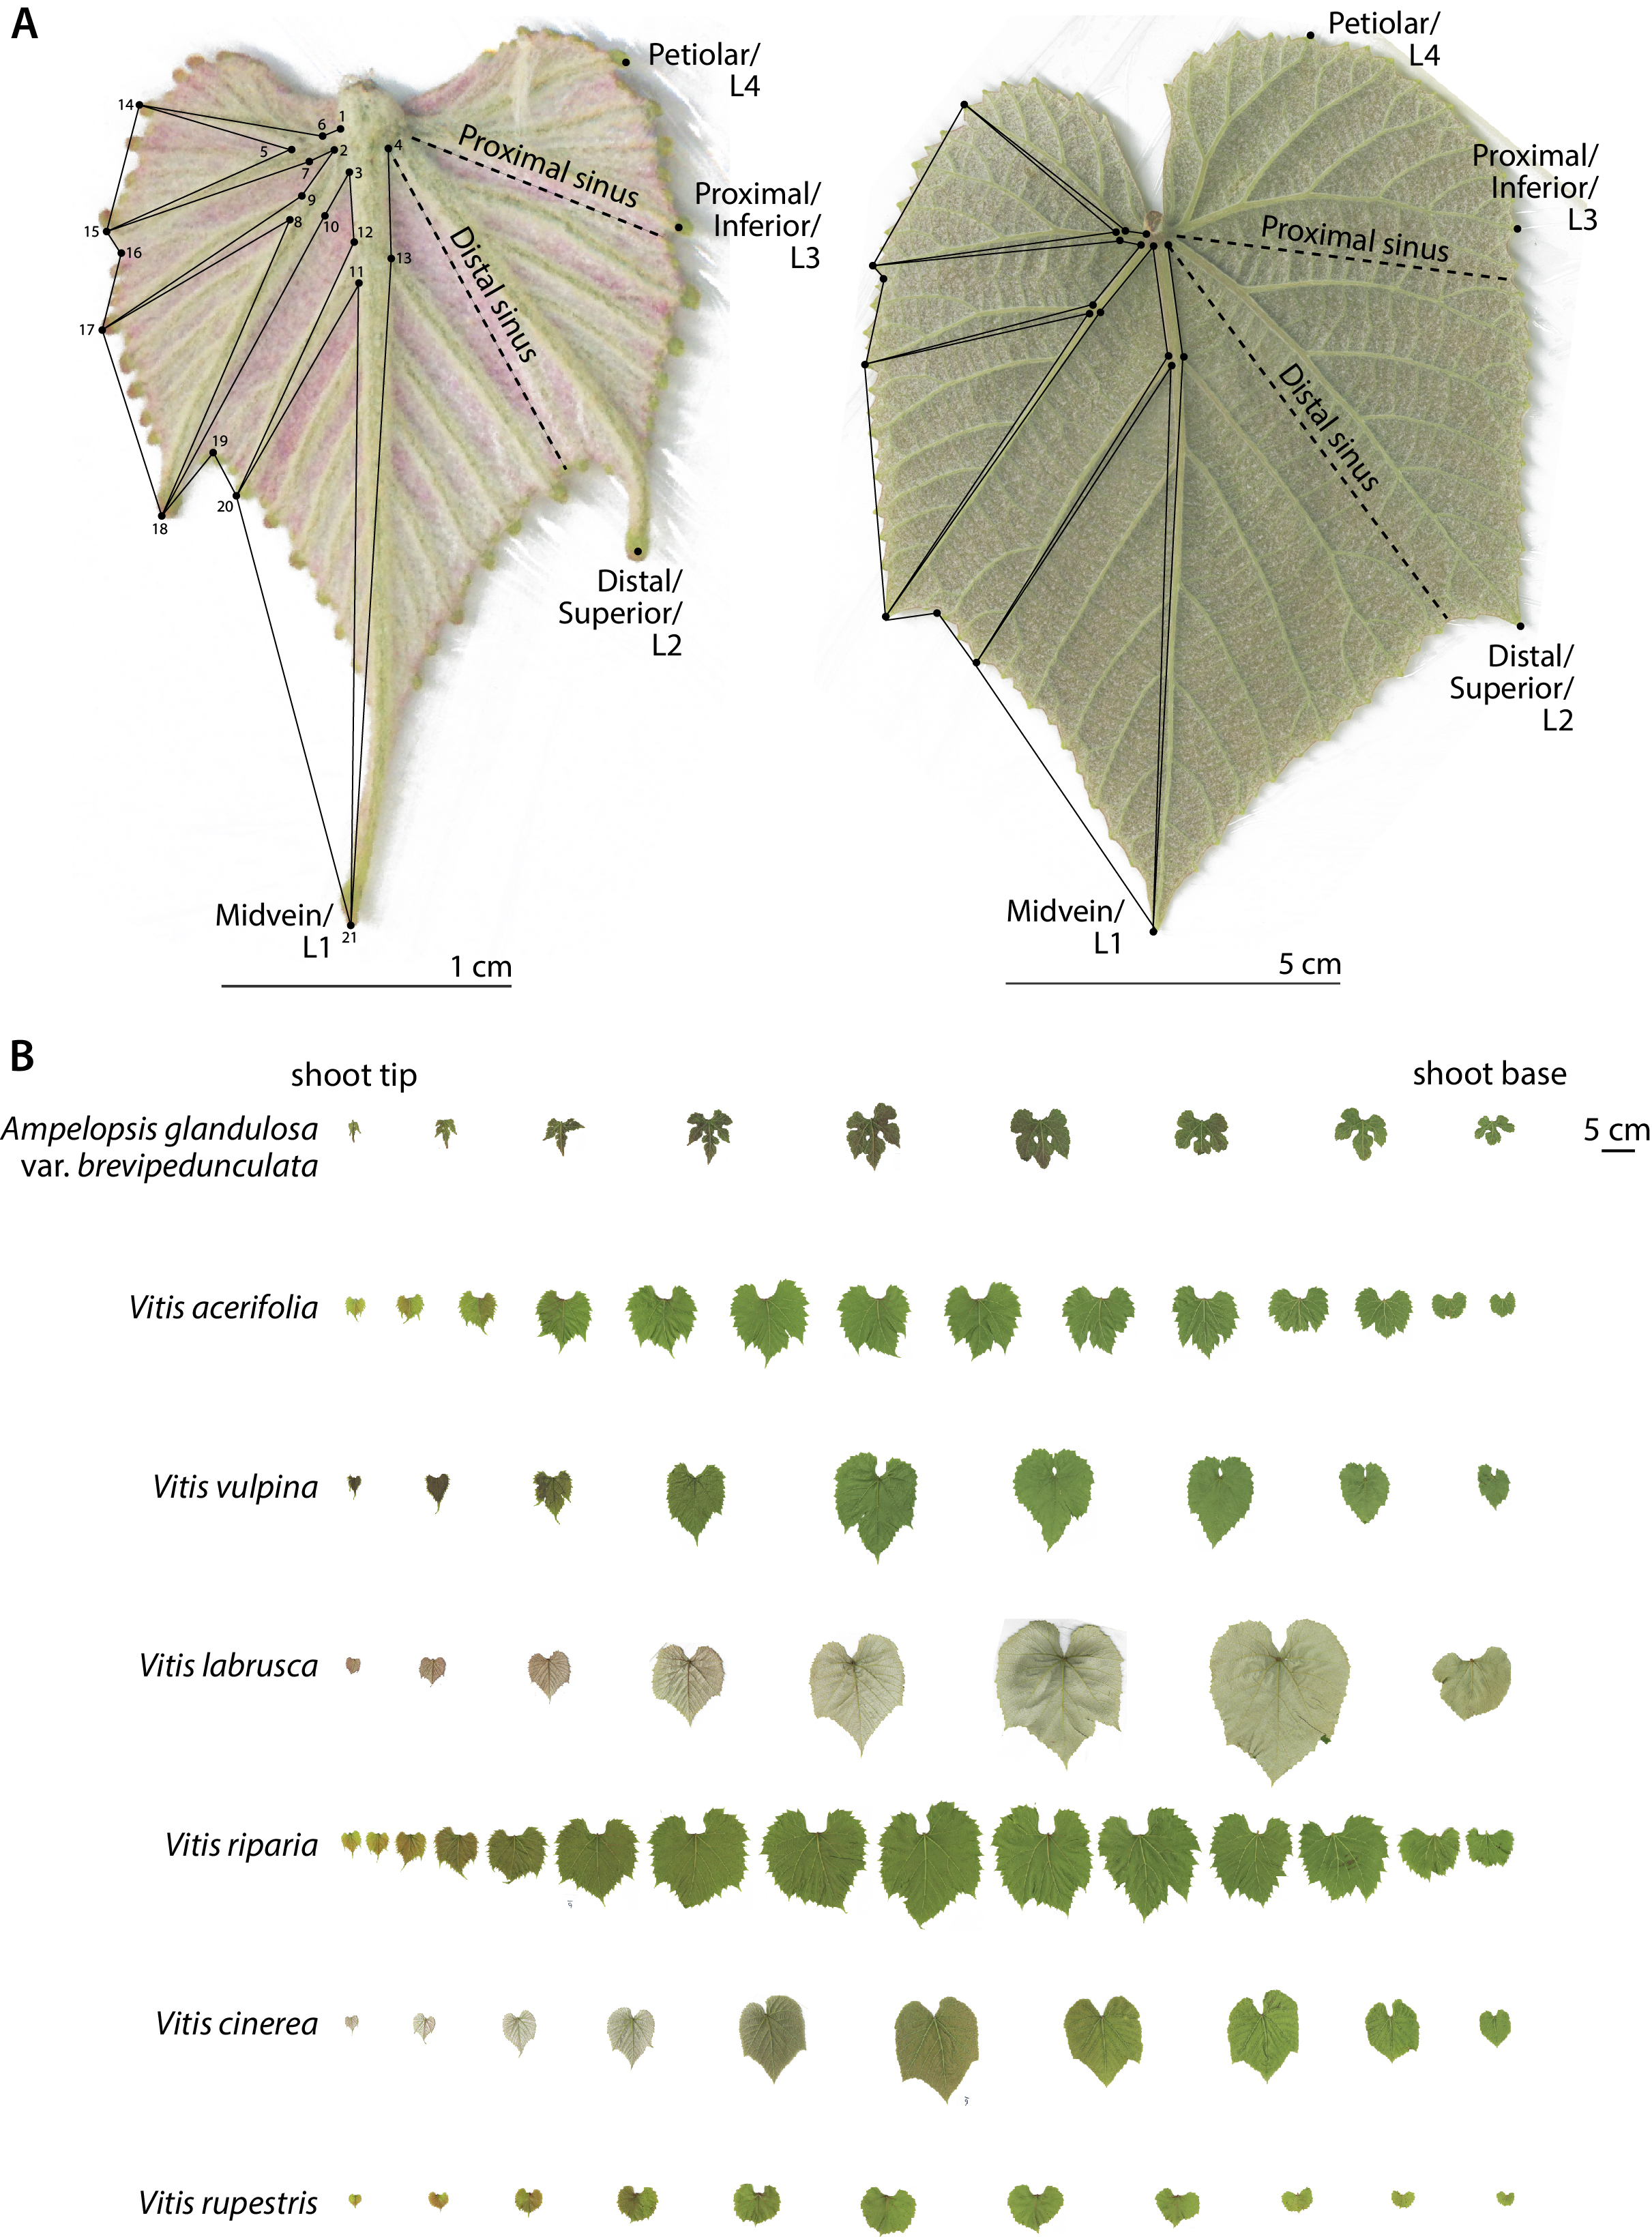

**A)** The first (left) and fifth (right) leaves, counting from the shoot tip, sampled from a *Vitis cinerea* shoot. The 21 landmarks used in this study are indicated, as well as the midvein/L1, distal/superior/L2 lobe, proximal/inferior/L3 lobe, petiolar/L4 branching vein, and distal and proximal sinuses. Scale bars for each leaf are shown (note that the younger leaf has a much higher ratio of vein to blade area compared to the more mtaure leaf). **B)** Leaves from some of the species sampled in this dataset. The shoot tip (left) and shoot base (right) are indicated and leaves sampled across the shoot are to scale (scale bar in the upper right).

# FIGURE 2
## MODELING VEIN-TO-BLADE RATIO AND LEAF AREA

In [4]:
#####
# Fit a polynomial of ln(vein-to-blade ratio) modeled as a function of normalized node position
#####

vtb_coefficients = np.polyfit(climate_data['normalized_node'],climate_data['vein_to_blade'],2)
vtb_func = np.poly1d(vtb_coefficients)
x_axis = np.linspace(min(climate_data['normalized_node']),max(climate_data['normalized_node']),100)
vtb_y_axis = vtb_func(x_axis)

#####
# Fit a polynomial of ln(area) modeled as a function of normalized node position
#####

area_coefficients = np.polyfit(climate_data['normalized_node'],np.log(climate_data['all_area']),2)
area_func = np.poly1d(area_coefficients)
x_axis = np.linspace(min(climate_data['normalized_node']),max(climate_data['normalized_node']),100)
area_y_axis = area_func(x_axis)

#####
# Create a function to solve for y given x
#####

def solve_for_y(poly_coeffs, y):
    pc = poly_coeffs.copy()
    pc[-1] -= y
    return np.roots(pc)

#####
# Given the minimum of the ln(vein-to-blade ratio) and maximum of ln(area) function, 
# solve for x value of normalized node position
#####

vtb_roots = solve_for_y(vtb_coefficients, min(vtb_y_axis))
area_roots = solve_for_y(area_coefficients, max(area_y_axis))

#####
# Take the average x value at the y minimum or maximum
#####

vtb_node_cutoff = np.mean(vtb_roots)
area_node_cutoff = np.mean(area_roots)

#####
# Print out the minimum ln(vein-to-blade ratio) normalized node value and
# Print out the maximum ln(area) normalized node value
#####

print("the minimum vein-to-blade ratio value is at normalized node position", vtb_node_cutoff)
print("the maximum ln(area) value is at normalized node position", area_node_cutoff)

the minimum vein-to-blade ratio value is at normalized node position 0.6481653537857041
the maximum ln(area) value is at normalized node position 0.6218086062963029


/Users/chitwood/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide


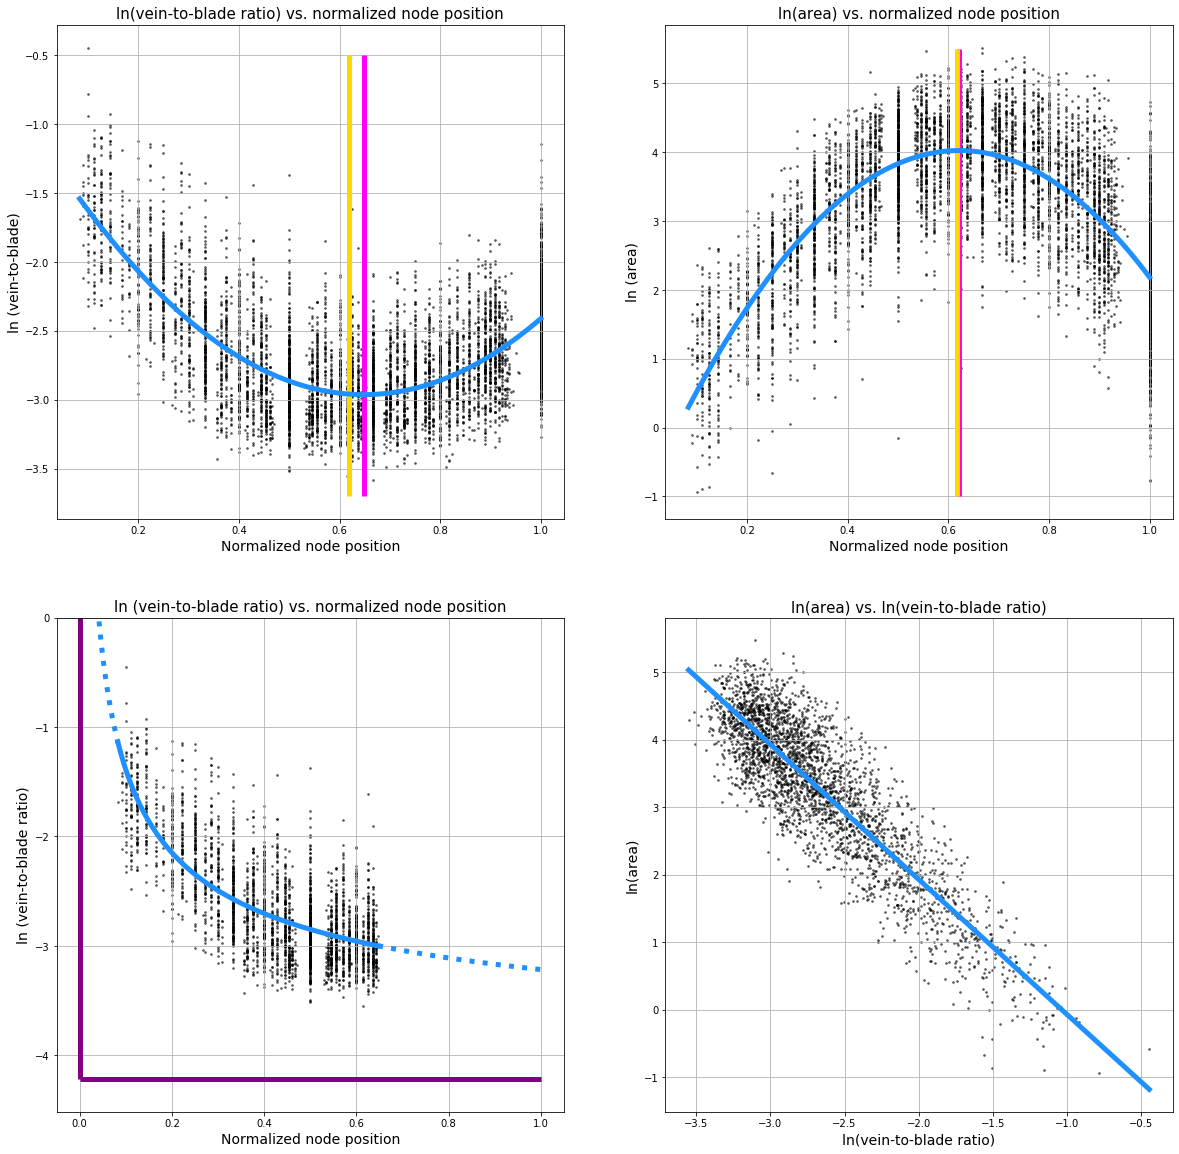

In [5]:
#####
# Visualize vein-to-blade ratio and ln(area) as a function of normalized node value
#####

# set figure size
plt.figure(figsize=(20,20))

################################################################
# Figure 2A: ln(vein to blade ratio) vs normalized node position
################################################################

# subplot for vein to blade ratio vs normalized node position
plt.subplot(221)
# show where in shoot we subset, using the ln(vein to blade) minimum normalized node position in magenta
plt.vlines(x=vtb_node_cutoff, ymin=-3.7, ymax=-0.5, linewidth=5, alpha=1, color="magenta") 
# show the inverse of the golden ratio in gold
plt.vlines(x=0.61803398875, ymin=-3.7, ymax=-0.5, linewidth=5, alpha=1, color="gold") 
# plot data, ln(vein to blade) vs normalized node position
plt.scatter(climate_data['normalized_node'],climate_data['vein_to_blade'], color="k", s=3, alpha=0.5)
# plot modeled polynomial function
plt.plot(x_axis, vtb_y_axis, color="dodgerblue", linewidth=5)
plt.xlabel('Normalized node position', fontsize = 14)
plt.ylabel('ln (vein-to-blade)', fontsize = 14)
plt.title('ln(vein-to-blade ratio) vs. normalized node position', fontsize = 15)
plt.grid()

#################################################
# Figure 2B: ln(area) vs normalized node position
#################################################

# subplot for ln(area) vs normalized node position
plt.subplot(222)
# show where in shoot we subset, using the ln(area) maximum normalized node position in magenta
plt.vlines(x=area_node_cutoff, ymin=-1, ymax=5.5, linewidth=5, alpha=1, color="magenta") 
# show the inverse of the golden ratio in gold
plt.vlines(x=0.61803398875, ymin=-1, ymax=5.5, linewidth=5, alpha=1, color="gold") 
# plot data, ln(area) vs normalized node position
plt.scatter(climate_data['normalized_node'],np.log(climate_data['all_area']), color="k", s=3, alpha=0.5)
# plot modeled polynomial function
plt.plot(x_axis, area_y_axis, color="dodgerblue", linewidth=5)
plt.xlabel('Normalized node position', fontsize = 14)
plt.ylabel('ln (area)', fontsize = 14)
plt.title('ln(area) vs. normalized node position', fontsize = 15)
plt.grid()

###############################################################################
# Figure 2C: ln(vein to blade ratio) vs normalized node position, only from tip
###############################################################################

# take only leaves from the developing tip using the vein-to-blade node cut off
from_tip_df = climate_data[ climate_data["normalized_node"]<vtb_node_cutoff   ]

# define a reciprocal function to fit to vein-to-blade vs normalized node position
def recip_func(x,k,a):
    return (1/(x)**(k)) + a

# fit curve and calculate function variables
popt, pcov = curve_fit(recip_func, from_tip_df['normalized_node'], from_tip_df['vein_to_blade'])

# save a_asymptote for min modeled vein-to-blade ratio late
a_asymp = popt[1]

# set graph x min and max values
xmin = 0
xmax = 1

# create the subplot
plt.subplot(223)
# plot data that has been subsetted for vein to blade vs normalized node
plt.scatter(from_tip_df['normalized_node'],from_tip_df['vein_to_blade'], color="k", s=3, alpha=0.5)
# plot out modeled values in DODGER BLUE
plt.plot(np.linspace(min(from_tip_df["normalized_node"]),max(from_tip_df["normalized_node"]),100),
            recip_func(np.linspace(min(from_tip_df["normalized_node"]),max(from_tip_df["normalized_node"]),100),popt[0],popt[1]), color="dodgerblue", linewidth=5)
# plot out extrapolated values, left in DODGER BLUE DASHED
plt.plot( np.linspace(0,min(from_tip_df["normalized_node"]),100),
            recip_func( np.linspace(0,min(from_tip_df["normalized_node"]),100),popt[0],popt[1]), color="dodgerblue", linewidth=5, linestyle="dotted")
# plot out extrapolated values, right in DODGER BLUE DASHED
plt.plot( np.linspace(max(from_tip_df["normalized_node"]),1,100),
            recip_func( np.linspace(max(from_tip_df["normalized_node"]),1,100),popt[0],popt[1]), color="dodgerblue", linewidth=5, linestyle="dotted")
# plot out the y axis asymptote in PURPLE
plt.hlines(y=popt[1],
              xmin=xmin, xmax=xmax, color="purple", linewidth=5)
# plot out the x axis asymptote in PURPLE
plt.vlines(x=0,
              ymin=popt[1], ymax=4, color="purple", linewidth=5)
plt.xlabel('Normalized node position', fontsize = 14)
plt.ylabel('ln (vein-to-blade ratio)', fontsize = 14)
plt.title('ln (vein-to-blade ratio) vs. normalized node position', fontsize = 15)
plt.ylim(a_asymp-0.3 ,0)
plt.grid()

################################################
# Figure 2D: ln(area) vs ln(vein to blade) ratio
################################################

# define a linear function to fit to ln(area) vs ln(vein-to-blade)
def linear_func(x,m,b):
    return (x*m) + b

# fit line and calculate function variables
popt, pcov = curve_fit(linear_func, from_tip_df['vein_to_blade'], np.log(from_tip_df['all_area']))

# save node min and max for vein to blade ratio values
xmin = min(from_tip_df['vein_to_blade']) # minimum vein to blade ratio value 
xmax = max(from_tip_df['vein_to_blade']) # maximum vein to blade ratio value

# create subplot
plt.subplot(224)

# plot data that has been subsetted for vein to blade vs normalized node
plt.scatter(from_tip_df['vein_to_blade'],np.log(from_tip_df['all_area']), color="k", s=3, alpha=0.5)
# plot out modeled values
plt.plot(np.linspace(xmin,xmax,100),
            linear_func(np.linspace(xmin,xmax,100),popt[0],popt[1]), color="dodgerblue", linewidth=5)
plt.xlabel('ln(vein-to-blade ratio)', fontsize = 14)
plt.ylabel('ln(area)', fontsize = 14)
plt.title('ln(area) vs. ln(vein-to-blade ratio)', fontsize = 15)
plt.grid()

plt.savefig("./figure_images/figure2.jpg")


# Figure 3
## MODELING AND VISUALIZING LEAF DEVELOPMENT ACROSS SPECIES

In [6]:
##### DETERMINE MOST REPRESENTED SPECIES TO MODEL
##### AND CREATE A LIST OF SPECIES TO VISUALIZE

print(from_tip_df["species_pop"].value_counts())

species_list = ["Ampelopsis_brevipedunculata",
                "Vitis_acerifolia",
                "Vitis_vulpina",
                "Vitis_labrusca",
                "Vitis_riparia",
                "Vitis_cinerea",
                "Vitis_rupestris"
               ]

Vitis_riparia                  1094
Vitis_labrusca                  427
Vitis_rupestris                 311
Vitis_cinerea                   304
Vitis_acerifolia                191
Vitis_spp                       174
Vitis_vulpina                   150
Vitis_amurensis                 134
Vitis_aestivalis                110
Vitis_palmata                    46
Vitis_coignetiae                 23
Vitis_x_doaniana                 20
Vitis_x_andersonii               17
Vitis_x_novae_angliae            15
Ampelopsis_brevipedunculata      12
Vitis_x_champinii                 3
Name: species_pop, dtype: int64


Ampelopsis_brevipedunculata
Vitis_acerifolia
Vitis_vulpina
Vitis_labrusca
Vitis_riparia
Vitis_cinerea
Vitis_rupestris


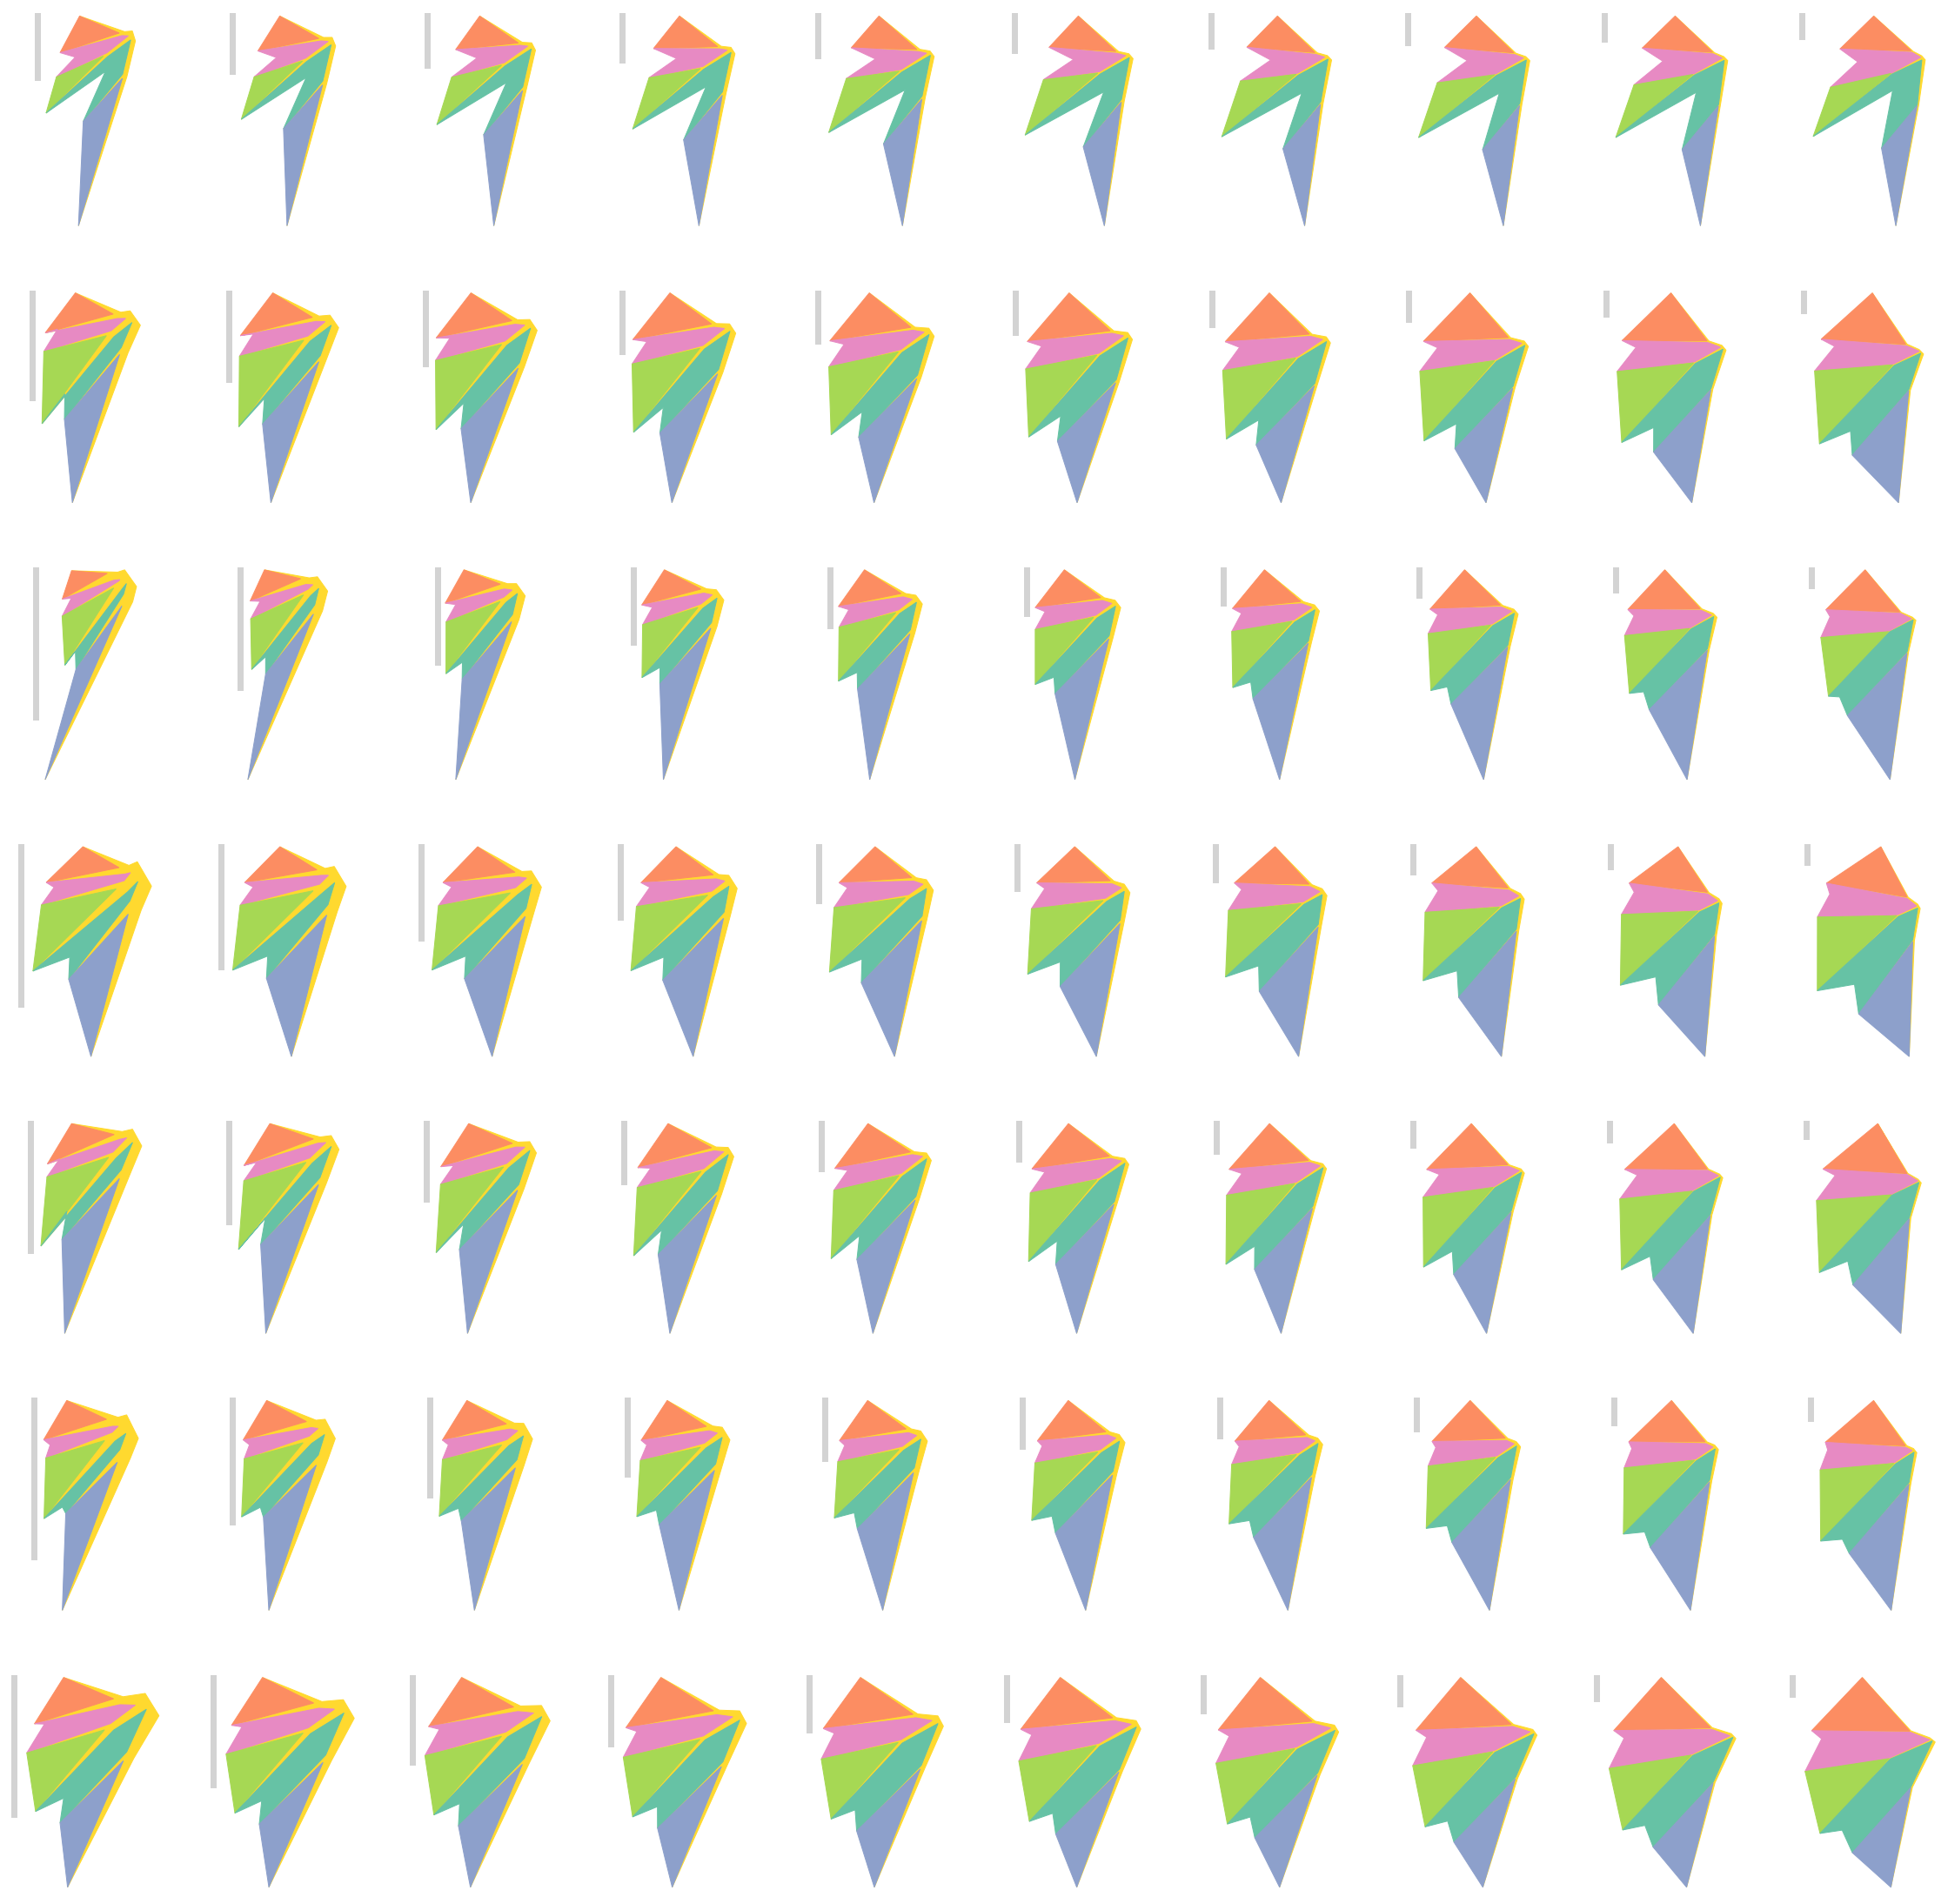

In [6]:
##### CREATE MODELS OF LEAF SHAPE AS FUNCTION OF VEIN-TO-BLADE RATIO #####

##### SELECT POLYNOMIAL ORDER AND TIME POINTS AND SCALE BAR OFFSET #####
order = 2 # order of polynomial
n = 10 # number of time points
buffer_x = 0.1 # offset to side of leaf for scale bar

##########################################################
#### VISUALIZE DEVELOPMENTAL MODELS FOR EACH SPECIES #####
##########################################################

vein_col = "#ffd92f"
prox_lobe_col = "#fc8d62"
prox_sinus_col = "#e78ac3"
dist_lobe_col = "#a6d854"
dist_sinus_col = "#66c2a5"
mid_lobe_col = "#8da0cb"

plt.figure(figsize=(40,40))
counter = 1

for s in range(len(species_list)):
    
    ##### SELECT SPECIES #####
    species = species_list[s]
    print(species)
    species_df = from_tip_df[ from_tip_df["species_pop"]==species ]
    
    ##### SET LIMITS OF MODEL TO MINIMUM AND MAXIMUM VEIN TO BLADE RATIO VALUES FOR SPECIES  #####
    xmin = min(species_df['vein_to_blade']) # minimum vein to blade ratio value 
    xmax = max(species_df['vein_to_blade']) # maximum vein to blade ratio value
    x_axis = np.linspace(xmin,xmax,n) # x values used to model

    ##### FOR VEIN-TO-BLADE RATIO VALUES, USE LINEAR MODEL TO PREDICT ABSOLUTE AREAS

    # create lists to store ln(vein-to-blade ratio) and ln(area) values from model
    lnvtb_values = [] # empty list to store ln(vein to blade) values
    lnarea_values = [] # empty list to store ln(area) values
    vtb_values = [] # empty list to store vein to blade ratio values
    area_values = [] # empty list to store area values

    for i in x_axis: # loop to calculate modeled values, for scaaling of leaf sizes

        lnvtb_val = i
        lnarea_val = linear_func(i,popt[0],popt[1]) # using coefficients fitted above
        vtb_val = math.e**(i)
        area_val = math.e**(linear_func(i,popt[0],popt[1]))

        lnvtb_values.append(lnvtb_val)
        lnarea_values.append(lnarea_val)
        vtb_values.append(vtb_val)
        area_values.append(area_val)

    ##### LISTS TO SAVE COOORDINATE VALUES #####

    x1val = [] # modeled values for each coord
    y1val = [] 
    x2val = [] 
    y2val = [] 
    x3val = [] 
    y3val = [] 
    x4val = [] 
    y4val = [] 
    x5val = [] 
    y5val = [] 
    x6val = [] 
    y6val = [] 
    x7val = [] 
    y7val = [] 
    x8val = [] 
    y8val = [] 
    x9val = [] 
    y9val = [] 
    x10val = [] 
    y10val = [] 
    x11val = [] 
    y11val = [] 
    x12val = [] 
    y12val = [] 
    x13val = [] 
    y13val = [] 
    x14val = [] 
    y14val = [] 
    x15val = [] 
    y15val = [] 
    x16val = [] 
    y16val = [] 
    x17val = [] 
    y17val = [] 
    x18val = [] 
    y18val = [] 
    x19val = [] 
    y19val = [] 
    x20val = [] 
    y20val = [] 
    x21val = [] 
    y21val = [] 

    #####
    # CREATE MODELS
    #####

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x1'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x1val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x2'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x2val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x3'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x3val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x4'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x4val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x5'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x5val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x6'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x6val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x7'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x7val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x8'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x8val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x9'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x9val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x10'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x10val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x11'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x11val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x12'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x12val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x13'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x13val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x14'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x14val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x15'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x15val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x16'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x16val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x17'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x17val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x18'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x18val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x19'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x19val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x20'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x20val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x21'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x21val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y1'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y1val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y2'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y2val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y3'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y3val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y4'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y4val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y5'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y5val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y6'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y6val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y7'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y7val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y8'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y8val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y9'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y9val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y10'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y10val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y11'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y11val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y12'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y12val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y13'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y13val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y14'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y14val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y15'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y15val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y16'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y16val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y17'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y17val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y18'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y18val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y19'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y19val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y20'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y20val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y21'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y21val.append(y_axis) # append modeled coord values

    ##### CALCCULATE CONVERSION FACTOR FROM PROCRUSTES TO ACTUAL SIZE #####

    proc_area_values = []
    proc_to_area = []

    for k in range(len(vtb_values)):

        proc_area = ((x4val[0][k]*y3val[0][k] + x3val[0][k]*y2val[0][k] + x2val[0][k]*y1val[0][k] + x1val[0][k]*y6val[0][k] + x6val[0][k]*y14val[0][k] + x14val[0][k]*y15val[0][k] + x15val[0][k]*y16val[0][k] + x16val[0][k]*y17val[0][k] + x17val[0][k]*y18val[0][k] + x18val[0][k]*y19val[0][k] + x19val[0][k]*y20val[0][k] + x20val[0][k]*y21val[0][k] + x21val[0][k]*y13val[0][k] + x13val[0][k]*y4val[0][k]) - (y4val[0][k]*x3val[0][k] + y3val[0][k]*x2val[0][k] + y2val[0][k]*x1val[0][k] + y1val[0][k]*x6val[0][k] + y6val[0][k]*x14val[0][k] + y14val[0][k]*x15val[0][k] + y15val[0][k]*x16val[0][k] + y16val[0][k]*x17val[0][k] + y17val[0][k]*x18val[0][k] + y18val[0][k]*x19val[0][k] + y19val[0][k]*x20val[0][k] + y20val[0][k]*x21val[0][k] + y21val[0][k]*x13val[0][k] + y13val[0][k]*x4val[0][k]))

        proc_area_values.append(proc_area)

        proc_to_area.append(math.sqrt(area_values[k])/math.sqrt(proc_area))
    
########################

    for v in range(n):

        i = (n-1)-v

        plt.subplot(7,10,counter)

        vein_xvals = np.multiply([x1val[0][i],x6val[0][i],x14val[0][i],x5val[0][i],x15val[0][i],x7val[0][i],
                 x2val[0][i],x9val[0][i],x17val[0][i],x8val[0][i],x18val[0][i],x10val[0][i],
                 x3val[0][i],x12val[0][i],x20val[0][i],x11val[0][i],x21val[0][i],x13val[0][i],
                 x4val[0][i]], proc_to_area[i])
        vein_yvals = np.multiply([y1val[0][i],y6val[0][i],y14val[0][i],y5val[0][i],y15val[0][i],y7val[0][i],
                 y2val[0][i],y9val[0][i],y17val[0][i],y8val[0][i],y18val[0][i],y10val[0][i],
                 y3val[0][i],y12val[0][i],y20val[0][i],y11val[0][i],y21val[0][i],y13val[0][i],
                 y4val[0][i]], proc_to_area[i])

        prox_lobe_xvals = np.multiply([x5val[0][i],x14val[0][i],x15val[0][i]], proc_to_area[i])
        prox_lobe_yvals = np.multiply([y5val[0][i],y14val[0][i],y15val[0][i]], proc_to_area[i])

        prox_sinus_xvals = np.multiply([x2val[0][i],x7val[0][i],x15val[0][i],x16val[0][i],x17val[0][i],x9val[0][i]], proc_to_area[i])
        prox_sinus_yvals = np.multiply([y2val[0][i],y7val[0][i],y15val[0][i],y16val[0][i],y17val[0][i],y9val[0][i]], proc_to_area[i])

        dist_lobe_xvals = np.multiply([x8val[0][i],x17val[0][i],x18val[0][i]], proc_to_area[i])
        dist_lobe_yvals = np.multiply([y8val[0][i],y17val[0][i],y18val[0][i]], proc_to_area[i])

        dist_sinus_xvals = np.multiply([x3val[0][i],x10val[0][i],x18val[0][i],x19val[0][i],x20val[0][i],x12val[0][i]], proc_to_area[i])
        dist_sinus_yvals = np.multiply([y3val[0][i],y10val[0][i],y18val[0][i],y19val[0][i],y20val[0][i],y12val[0][i]], proc_to_area[i])

        mid_lobe_xvals = np.multiply([x11val[0][i],x20val[0][i],x21val[0][i]], proc_to_area[i])
        mid_lobe_yvals = np.multiply([y11val[0][i],y20val[0][i],y21val[0][i]], proc_to_area[i])

        plt.fill(vein_xvals,vein_yvals, c=vein_col)
        plt.fill(prox_lobe_xvals,prox_lobe_yvals, c=prox_lobe_col)
        plt.fill(prox_sinus_xvals,prox_sinus_yvals, c=prox_sinus_col)
        plt.fill(dist_lobe_xvals,dist_lobe_yvals, c=dist_lobe_col)
        plt.fill(dist_sinus_xvals,dist_sinus_yvals, c=dist_sinus_col)
        plt.fill(mid_lobe_xvals,mid_lobe_yvals, c=mid_lobe_col)

        # calculate a scale bar of 1 c

        min_x_plot = np.min(vein_xvals)
        max_x_plot = np.max(vein_xvals)
        min_y_plot = np.min(vein_yvals)
        max_y_plot = np.max(vein_yvals)
        diff_x = np.max(vein_xvals) - np.min(vein_xvals)
        diff_y = np.max(vein_yvals) - np.min(vein_yvals)
        scale_x = [min_x_plot - buffer_x*diff_x, min_x_plot - buffer_x*diff_x]
        scale_y = [max_y_plot, max_y_plot-1] 
        plt.plot(scale_x, scale_y, linewidth=7, c="lightgrey")

        plt.gca().set_aspect("equal")
        plt.axis("off")

        counter += 1
        
plt.savefig("./figure_images/figure3.jpg" )

# FIGURE 4
## PRINCIPAL COMPONENT ANALYSIS, INVERSE TRANSFORM, PROJECTION OF DATA

In [7]:
###########################################################
##### CREATE MODELS OF EACH SPECIES TO PROJECT ONTO THE PCA
###########################################################

# PICK SPECIES TO MODEL

species_list = ["Ampelopsis_brevipedunculata",
                "Vitis_acerifolia",
                "Vitis_vulpina",
                "Vitis_labrusca",
                "Vitis_riparia",
                "Vitis_cinerea",
                "Vitis_rupestris"
               ]

order = 2 # order of polynomial
n = 100 # number of time points

##### LISTS TO SAVE SHAPES #####

x1val = [] # modeled values for each coord
y1val = [] 
x2val = [] 
y2val = [] 
x3val = [] 
y3val = [] 
x4val = [] 
y4val = [] 
x5val = [] 
y5val = [] 
x6val = [] 
y6val = [] 
x7val = [] 
y7val = [] 
x8val = [] 
y8val = [] 
x9val = [] 
y9val = [] 
x10val = [] 
y10val = [] 
x11val = [] 
y11val = [] 
x12val = [] 
y12val = [] 
x13val = [] 
y13val = [] 
x14val = [] 
y14val = [] 
x15val = [] 
y15val = [] 
x16val = [] 
y16val = [] 
x17val = [] 
y17val = [] 
x18val = [] 
y18val = [] 
x19val = [] 
y19val = [] 
x20val = [] 
y20val = [] 
x21val = [] 
y21val = [] 

for spe in species_list:

    ##### SELECT SPECIES #####
    species = spe
    species_df = from_tip_df[ from_tip_df["species_pop"]==species ]

    xmin = min(species_df['vein_to_blade']) # minimum vein to blade ratio value 
    xmax = max(species_df['vein_to_blade']) # maximum vein to blade ratio value
    x_axis = np.linspace(xmin,xmax,n) # x values used to mode

    #####
    # CREATE MODELS
    #####

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x1'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x1val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x2'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x2val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x3'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x3val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x4'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x4val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x5'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x5val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x6'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x6val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x7'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x7val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x8'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x8val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x9'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x9val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x10'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x10val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x11'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x11val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x12'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x12val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x13'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x13val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x14'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x14val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x15'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x15val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x16'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x16val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x17'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x17val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x18'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x18val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x19'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x19val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x20'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x20val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['x21'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    x21val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y1'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y1val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y2'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y2val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y3'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y3val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y4'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y4val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y5'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y5val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y6'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y6val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y7'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y7val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y8'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y8val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y9'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y9val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y10'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y10val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y11'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y11val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y12'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y12val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y13'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y13val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y14'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y14val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y15'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y15val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y16'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y16val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y17'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y17val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y18'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y18val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y19'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y19val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y20'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y20val.append(y_axis) # append modeled coord values

    coefficients = np.polyfit(species_df['vein_to_blade'],species_df['y21'],order) # create coefficients for current coordinate
    func = np.poly1d(coefficients) # create function of current coord vs vein-to-blade values
    y_axis = func(x_axis) # calculate modeled coord values
    y21val.append(y_axis) # append modeled coord values

##############################################
##### CREATE PANDAS DATAFRAME OF MODEL RESULTS
##############################################

df_list = []

for i in range(len(species_list)):
    
    model_dict = {"species":species_list[i],
                  "x1":x1val[i],"y1":y1val[i],
                  "x2":x2val[i],"y2":y2val[i],
                  "x3":x3val[i],"y3":y3val[i],
                  "x4":x4val[i],"y4":y4val[i],
                  "x5":x5val[i],"y5":y5val[i],
                  "x6":x6val[i],"y6":y6val[i],
                  "x7":x7val[i],"y7":y7val[i],
                  "x8":x8val[i],"y8":y8val[i],
                  "x9":x9val[i],"y9":y9val[i],
                  "x10":x10val[i],"y10":y10val[i],
                  "x11":x11val[i],"y11":y11val[i],
                  "x12":x12val[i],"y12":y12val[i],
                  "x13":x13val[i],"y13":y13val[i],
                  "x14":x14val[i],"y14":y14val[i],
                  "x15":x15val[i],"y15":y15val[i],
                  "x16":x16val[i],"y16":y16val[i],
                  "x17":x17val[i],"y17":y17val[i],
                  "x18":x18val[i],"y18":y18val[i],
                  "x19":x19val[i],"y19":y19val[i],
                  "x20":x20val[i],"y20":y20val[i],
                  "x21":x21val[i],"y21":y21val[i]
                 }
               
    modeled_species_df = pd.DataFrame(model_dict)
               
    df_list.append(modeled_species_df )

models_species_df = pd.concat(df_list)

models_species_df
    

species          x1          y1          x2  \
0   Ampelopsis_brevipedunculata  428.618995  394.152681  415.838800   
1   Ampelopsis_brevipedunculata  428.855510  393.866553  415.088808   
2   Ampelopsis_brevipedunculata  429.088472  393.611384  414.345694   
3   Ampelopsis_brevipedunculata  429.317880  393.387174  413.609456   
4   Ampelopsis_brevipedunculata  429.543736  393.193924  412.880095   
..                          ...         ...         ...         ...   
95              Vitis_rupestris  575.078190  569.910813  459.411618   
96              Vitis_rupestris  574.382070  572.778040  457.845141   
97              Vitis_rupestris  573.672346  575.662258  456.272291   
98              Vitis_rupestris  572.949016  578.563469  454.693067   
99              Vitis_rupestris  572.212082  581.481672  453.107470   

            y2          x3          y3          x4          y4          x5  \
0   372.334819  430.737037  333.419055  481.063045  334.903044  275.837731   
1   372.213701  431.470723  333.887623  481.800028  334.766555  274.763360   
2   372.109719  432.185202  334.356903  482.521869  334.639609  273.703425   
3   372.022873  432.880476  334.826896  483.228568  334.522206  272.657927   
4   371.953164  433.556544  335.297601  483.920124  334.414345  271.626865   
..         ...         ...         ...         ...         ...         ...   
95  438.820465  586.881791  390.111900  729.057744  316.553486  200.649763   
96  439.377625  586.793658  390.471626  731.338177  315.685238  198.400898   
97  439.926708  586.709180  390.826779  733.648336  314.799790  196.132497   
98  440.467716  586.628356  391.177359  735.988222  313.897144  193.844561   
99  441.000648  586.551186  391.523365  738.357835  312.977300  191.537090   

    ...         x17         y17          x18         y18         x19  \
0   ... -903.636592  -65.607233 -1156.307355 -783.098558    4.444998   
1   ... -902.777009  -61.202786 -1157.101286 -784.629071    6.482218   
2   ... -901.892503  -56.909842 -1157.816140 -786.112807    8.483689   
3   ... -900.983077  -52.728401 -1158.451917 -787.549765   10.449409   
4   ... -900.048728  -48.658462 -1159.008615 -788.939946   12.379380   
..  ...         ...         ...          ...         ...         ...   
95  ... -856.191406 -128.682483  -749.215195 -840.698112 -414.864378   
96  ... -855.524525 -130.096717  -748.734049 -840.355386 -413.611136   
97  ... -854.876373 -131.523748  -748.257244 -840.005349 -412.357897   
98  ... -854.246952 -132.963575  -747.784782 -839.647999 -411.104659   
99  ... -853.636260 -134.416198  -747.316663 -839.283337 -409.851424   

           y19         x20         y20         x21          y21  
0  -112.809451 -157.332911 -958.307512   51.043379 -2088.980259  
1  -114.963341 -159.820417 -960.362410   55.092296 -2089.665118  
2  -117.068207 -162.285965 -962.349345   58.972144 -2090.397766  
3  -119.124050 -164.729557 -964.268318   62.682923 -2091.178203  
4  -121.130869 -167.151193 -966.119328   66.224632 -2092.006430  
..         ...         ...         ...         ...          ...  
95 -683.831588 -453.394703 -977.726648 -353.197916 -1753.122185  
96 -682.674982 -453.330142 -977.603968 -355.565269 -1752.803466  
97 -681.519379 -453.253325 -977.502282 -357.885762 -1752.427688  
98 -680.364780 -453.164251 -977.421588 -360.159393 -1751.994852  
99 -679.211184 -453.062921 -977.361887 -362.386164 -1751.504958  

[700 rows x 43 columns]

In [8]:
########################################################################
### PERFORM PCA FIRST WITH ALL PCs TO SEE HOW MUCH VARIANCE IS EXPLAINED
########################################################################

# take all climate and lobing dataset leaves, only the landmarks
just_landmarks_data =df[['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4',
       'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10',
       'y10', 'x11', 'y11', 'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'x15',
       'y15', 'x16', 'y16', 'x17', 'y17', 'x18', 'y18', 'x19', 'y19', 'x20',
       'y20', 'x21', 'y21']]

# (this is modeled species data for later)
just_landmarks_spe_data = models_species_df[['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4',
       'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10',
       'y10', 'x11', 'y11', 'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'x15',
       'y15', 'x16', 'y16', 'x17', 'y17', 'x18', 'y18', 'x19', 'y19', 'x20',
       'y20', 'x21', 'y21']]

# convert to numpy array for PCA
raw_data = pd.DataFrame(just_landmarks_data).to_numpy() 

# (this is modeled species data for later)
spe_raw_data = pd.DataFrame(just_landmarks_spe_data).to_numpy() 

# perform the PCA with all possible PCs (x42)
test_pca = PCA(n_components=42)
test_PCs = test_pca.fit_transform(raw_data)

print(test_pca.explained_variance_ratio_) # print variance explained for each PC
print(test_pca.explained_variance_ratio_.cumsum()) # print cumulative variance for each PC

[3.97453686e-01 1.75757269e-01 1.39292781e-01 4.72664301e-02
 4.50666953e-02 3.07112323e-02 2.57275314e-02 2.40376600e-02
 1.79311324e-02 1.60722545e-02 1.50228333e-02 1.28725439e-02
 1.02964264e-02 8.58971032e-03 6.47232288e-03 6.30695886e-03
 4.20997517e-03 3.74509972e-03 3.42782291e-03 3.25820380e-03
 2.34454496e-03 1.96469442e-03 6.98648357e-04 4.63134678e-04
 2.46690759e-04 1.38323593e-04 9.90692534e-05 7.99665589e-05
 7.45891468e-05 6.08308967e-05 5.24425026e-05 4.77280450e-05
 4.50466000e-05 4.07036049e-05 3.46612885e-05 2.94338006e-05
 2.56655021e-05 2.01465698e-05 1.51093629e-05 2.80943245e-10
 1.87356986e-14 4.25525712e-15]
[0.39745369 0.57321096 0.71250374 0.75977017 0.80483686 0.83554809
 0.86127563 0.88531329 0.90324442 0.91931667 0.93433951 0.94721205
 0.95750848 0.96609819 0.97257051 0.97887747 0.98308744 0.98683254
 0.99026037 0.99351857 0.99586311 0.99782781 0.99852646 0.99898959
 0.99923628 0.99937461 0.99947368 0.99955364 0.99962823 0.99968906
 0.9997415  0.99978923 

In [9]:
###############################################################
### PERFORM PCA WITH JUST THE FIRST TWO PCs FOR ACTUAL ANALYSIS
###############################################################

# Define the PCA function below, using two components (PC1 and PC2)
pca = PCA(n_components=2)

# Now apply the sklearn pca function with two components to the dataset
data_PCs = pca.fit_transform(raw_data)

# Now PROJECT the modeled species data onto the same PCA (modeled data not included in calculation of PCA)
spe_model_PCs = pca.transform(spe_raw_data)

# The inverse transform function is applied
inverse_PCA = pca.inverse_transform(data_PCs)

# Add PCs to the existing dataframe info and call "data_PCs_info"
data_PCs = pd.DataFrame(data_PCs)
data_PCs.columns = ['PC1','PC2']
data_PCs_info = pd.concat([df.reset_index(drop=True), data_PCs.reset_index(drop=True)], axis=1)

# Add projected species model PCs to the existing info and call "spe_model_PCs"
spe_model_PCs = pd.DataFrame(spe_model_PCs)
spe_model_PCs.columns = ['PC1','PC2']
spe_model_PCs = pd.concat([models_species_df["species"].reset_index(drop=True), spe_model_PCs.reset_index(drop=True)], axis=1)


In [10]:
#######################################################
### PERFORM INVERSE PCA TO CALCULATE THEORETICAL LEAVES
### AND THEIR VEIN-TO-BLADE RATIO AND DISTAL LOBING
#######################################################

# store PC coordinates and theoretical vein-to-blade and distal lobing values

x_vals = []
y_vals = []
distal_lobing_vals = []
vein_to_blade_vals = []
distal_lobing_contour = []
vein_to_blade_contour = []

# create grid system across PC1 (x_vals) and PC2 (y_vals) to loop over

just_xvals = np.linspace(-1500, 2000, 50)
just_yvals = np.linspace(-1500, 2000, 50)

# loop over grid of PCA values and calculate theoretical leaves using inverse PCA
# from inverse calculated leaves, calculate vein-to-blade ratio and distal lobing

for i in just_xvals:
    
    print(i)
    
    distal_lobing_convals = [] # for a list of lists
    vein_to_blade_convals = []
    
    for j in just_yvals:
        
        inverse_PCA = pca.inverse_transform(np.array([i,j]))
        
        inverse_df = pd.DataFrame(inverse_PCA)
        trans_df = inverse_df.T
        trans_df.columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4',
               'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10',
               'y10', 'x11', 'y11', 'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'x15',
               'y15', 'x16', 'y16', 'x17', 'y17', 'x18', 'y18', 'x19', 'y19', 'x20',
               'y20', 'x21', 'y21']
        
        # Calculate the overall area of a leaf using the shoestring algorithm

        # Note: These are Procrustes coordinates, so not absolute area,
        # but ultimately we are calculating a ratio of vein-to-blade area

        # First, calculate the overall area of a leaf

        trans_df['all_area'] = (0.5)*abs(

        (trans_df['x4']*trans_df['y3'] + trans_df['x3']*trans_df['y2'] + trans_df['x2']*trans_df['y1'] + trans_df['x1']*trans_df['y6'] + trans_df['x6']*trans_df['y14'] + trans_df['x14']*trans_df['y15'] + trans_df['x15']*trans_df['y16'] + trans_df['x16']*trans_df['y17'] + trans_df['x17']*trans_df['y18'] + trans_df['x18']*trans_df['y19'] + trans_df['x19']*trans_df['y20'] + trans_df['x20']*trans_df['y21'] + trans_df['x21']*trans_df['y13'] + trans_df['x13']*trans_df['y4']) - 

        (trans_df['y4']*trans_df['x3'] + trans_df['y3']*trans_df['x2'] + trans_df['y2']*trans_df['x1'] + trans_df['y1']*trans_df['x6'] + trans_df['y6']*trans_df['x14'] + trans_df['y14']*trans_df['x15'] + trans_df['y15']*trans_df['x16'] + trans_df['y16']*trans_df['x17'] + trans_df['y17']*trans_df['x18'] + trans_df['y18']*trans_df['x19'] + trans_df['y19']*trans_df['x20'] + trans_df['y20']*trans_df['x21'] + trans_df['y21']*trans_df['x13'] + trans_df['y13']*trans_df['x4']) 

        )

        # Next, calculate the area of the vasculature starting with the proximal vein & branch

        trans_df['prox'] = (0.5)*abs(

        (trans_df['x2']*trans_df['y1'] + trans_df['x1']*trans_df['y6'] + trans_df['x6']*trans_df['y14'] + trans_df['x14']*trans_df['y5'] + trans_df['x5']*trans_df['y15'] + trans_df['x15']*trans_df['y7'] + trans_df['x7']*trans_df['y2']) -

        (trans_df['y2']*trans_df['x1'] + trans_df['y1']*trans_df['x6'] + trans_df['y6']*trans_df['x14'] + trans_df['y14']*trans_df['x5'] + trans_df['y5']*trans_df['x15'] + trans_df['y15']*trans_df['x7'] + trans_df['y7']*trans_df['x2'])

        )

        # Then the distal vein and branch

        trans_df['dist'] = (0.5)*abs(

        (trans_df['x3']*trans_df['y2'] + trans_df['x2']*trans_df['y9'] + trans_df['x9']*trans_df['y17'] + trans_df['x17']*trans_df['y8'] + trans_df['x8']*trans_df['y18'] + trans_df['x18']*trans_df['y10'] + trans_df['x10']*trans_df['y3']) -

        (trans_df['y3']*trans_df['x2'] + trans_df['y2']*trans_df['x9'] + trans_df['y9']*trans_df['x17'] + trans_df['y17']*trans_df['x8'] + trans_df['y8']*trans_df['x18'] + trans_df['y18']*trans_df['x10'] + trans_df['y10']*trans_df['x3'])

        )


        # And the area of the midvein and its branch

        trans_df['mid'] = (0.5)*abs(

        (trans_df['x4']*trans_df['y3'] + trans_df['x3']*trans_df['y12'] + trans_df['x12']*trans_df['y20'] + trans_df['x20']*trans_df['y11'] + trans_df['x11']*trans_df['y21'] + trans_df['x21']*trans_df['y13'] + trans_df['x13']*trans_df['y4']) -

        (trans_df['y4']*trans_df['x3'] + trans_df['y3']*trans_df['x12'] + trans_df['y12']*trans_df['x20'] + trans_df['y20']*trans_df['x11'] + trans_df['y11']*trans_df['x21'] + trans_df['y21']*trans_df['x13'] + trans_df['y13']*trans_df['x4'])

        )

        # Then calculate the overall vein area as the sum of the proximal, distal, and midveins

        trans_df['veins'] = trans_df['prox'] + trans_df['dist'] + trans_df['mid']

        # Calculate blade area as the overall area of the leaf minus vein area

        trans_df['blade'] = trans_df['all_area'] - trans_df['veins']

        # Calculate vein-to-blade ratio 
        # We use natural log transformation which makes the distribution more normal

        trans_df["vein_to_blade"] = np.log(trans_df['veins'] / trans_df['blade'])
        
        trans_df["distal_lobe_depth"] = np.sqrt((trans_df['x19']-trans_df['x3'])**2 + (trans_df['y19']-trans_df['y3'])**2)/np.sqrt((trans_df['x18']-trans_df['x3'])**2 + (trans_df['y18']-trans_df['y3'])**2)
        
        x_vals.append(i) # append PC1 vals
        y_vals.append(j) # append PC2 vals
        distal_lobing_vals.append(trans_df["distal_lobe_depth"][0]) # append values to a flat list
        vein_to_blade_vals.append(trans_df["vein_to_blade"][0]   )
        distal_lobing_convals.append(trans_df["distal_lobe_depth"][0]) # append values to make a list of lists
        vein_to_blade_convals.append(trans_df["vein_to_blade"][0]   )
        
    distal_lobing_contour.append(distal_lobing_convals) # append list to list
    vein_to_blade_contour.append(vein_to_blade_convals)

# create a dataframe with PC values aand theoretical vein-to-blade and distal lobing values
    
inverse_df = pd.DataFrame({"PC1":x_vals, "PC2":y_vals,"vein_to_blade":vein_to_blade_vals, "distal_lobing":distal_lobing_vals})

inverse_df


-1500.0
-1428.5714285714287
-1357.142857142857
-1285.7142857142858
-1214.2857142857142
-1142.857142857143
-1071.4285714285716
-1000.0
-928.5714285714286
-857.1428571428571
-785.7142857142857
-714.2857142857142
-642.8571428571429
-571.4285714285714
-500.0
-428.57142857142844
-357.1428571428571
-285.7142857142858
-214.28571428571422
-142.8571428571429
-71.42857142857133
0.0
71.42857142857156
142.8571428571429
214.28571428571422
285.7142857142858
357.1428571428571
428.57142857142867
500.0
571.4285714285716
642.8571428571431
714.2857142857142
785.7142857142858
857.1428571428573
928.5714285714284
1000.0
1071.4285714285716
1142.8571428571431
1214.2857142857142
1285.7142857142858
1357.1428571428573
1428.5714285714284
1500.0
1571.4285714285716
1642.8571428571431
1714.2857142857142
1785.7142857142858
1857.1428571428573
1928.5714285714284
2000.0


PC1          PC2  vein_to_blade  distal_lobing
0    -1500.0 -1500.000000      -2.526617       1.862726
1    -1500.0 -1428.571429      -2.510854       1.829003
2    -1500.0 -1357.142857      -2.495151       1.795583
3    -1500.0 -1285.714286      -2.479520       1.762462
4    -1500.0 -1214.285714      -2.463972       1.729635
...      ...          ...            ...            ...
2495  2000.0  1714.285714      -1.474212       0.654848
2496  2000.0  1785.714286      -1.340925       0.675326
2497  2000.0  1857.142857      -1.188048       0.695641
2498  2000.0  1928.571429      -1.008823       0.715794
2499  2000.0  2000.000000      -0.792164       0.735787

[2500 rows x 4 columns]

0
1
2
3
4
5
6
7
8
9
[-2.93997533 -2.84643386 -2.75289238 -2.6593509  -2.56580943 -2.47226795
 -2.37872647 -2.28518499 -2.19164352 -2.09810204]


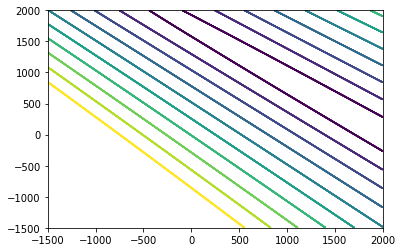

In [11]:
##################################################
### CALCULATE ISOLINES ACROSS DISTAL LOBING VALUES
##################################################

# specify contour levels of distal lobing to analyze
contour_levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] 

contour_xvals = [] # store xvals and yvals of contour isolines for distaal lobing
contour_yvals = []

for i in range(10): # loop through each contour level of distal lobing, store as list of lists
 
    cs = plt.contour(list(just_xvals),list(just_yvals),distal_lobing_contour, contour_levels)
    p1 = cs.collections[i].get_paths()[0]  # grab the 1st path
    coor_p1 = p1.vertices
    xvals = coor_p1[:,0]
    yvals = coor_p1[:,1]
    
    contour_xvals.append(xvals)
    contour_yvals.append(yvals)
    
# create function to interpolate across isolines so they have same number, equally spaced points
def interpolation(x, y, number):

    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

# loop through and store interpolated distal lobing isolines with the same number of points
xinter_vals = []
yinter_vals = []
number_points = 500

for i in range(10):
    
    xinter, yinter = interpolation(contour_xvals[i], contour_yvals[i], number_points)
    
    xinter_vals.append(xinter)
    yinter_vals.append(yinter)
    
##################################################################
### ACROSS INTERPOLATAED DISTAL LOBING ISOLINES
### CALCULATAE THEORETICAL VEIN-TO-BLADE and DISTAL LOBING VALUES
##################################################################
     
number_points = 500

PC1_contours = []
PC2_contours = []
vtb_contours = []
distal_contours = []

for i in range(10):
    
    print(i)
    
    curr_inter_xvals = xinter_vals[i]
    curr_inter_yvals = yinter_vals[i]
    
    PC1_vals = []
    PC2_vals = []
    distal_lobing_convals  = []
    vein_to_blade_convals  = []
    
    for j in range(number_points):
        
        curr_inter_xval = curr_inter_xvals[j]
        curr_inter_yval = curr_inter_yvals[j]
        
        inverse_PCA = pca.inverse_transform(np.array([curr_inter_xval,curr_inter_yval]))
        
        inverse_df2 = pd.DataFrame(inverse_PCA)
        trans_df = inverse_df2.T
        trans_df.columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4',
               'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10',
               'y10', 'x11', 'y11', 'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'x15',
               'y15', 'x16', 'y16', 'x17', 'y17', 'x18', 'y18', 'x19', 'y19', 'x20',
               'y20', 'x21', 'y21']
        
        # Calculate the overall area of a leaf using the shoestring algorithm

        # Note: These are Procrustes coordinates, so not absolute area,
        # but ultimately we are calculating a ratio of vein-to-blade area

        # First, calculate the overall area of a leaf

        trans_df['all_area'] = (0.5)*abs(

        (trans_df['x4']*trans_df['y3'] + trans_df['x3']*trans_df['y2'] + trans_df['x2']*trans_df['y1'] + trans_df['x1']*trans_df['y6'] + trans_df['x6']*trans_df['y14'] + trans_df['x14']*trans_df['y15'] + trans_df['x15']*trans_df['y16'] + trans_df['x16']*trans_df['y17'] + trans_df['x17']*trans_df['y18'] + trans_df['x18']*trans_df['y19'] + trans_df['x19']*trans_df['y20'] + trans_df['x20']*trans_df['y21'] + trans_df['x21']*trans_df['y13'] + trans_df['x13']*trans_df['y4']) - 

        (trans_df['y4']*trans_df['x3'] + trans_df['y3']*trans_df['x2'] + trans_df['y2']*trans_df['x1'] + trans_df['y1']*trans_df['x6'] + trans_df['y6']*trans_df['x14'] + trans_df['y14']*trans_df['x15'] + trans_df['y15']*trans_df['x16'] + trans_df['y16']*trans_df['x17'] + trans_df['y17']*trans_df['x18'] + trans_df['y18']*trans_df['x19'] + trans_df['y19']*trans_df['x20'] + trans_df['y20']*trans_df['x21'] + trans_df['y21']*trans_df['x13'] + trans_df['y13']*trans_df['x4']) 

        )

        # Next, calculate the area of the vasculature starting with the proximal vein & branch

        trans_df['prox'] = (0.5)*abs(

        (trans_df['x2']*trans_df['y1'] + trans_df['x1']*trans_df['y6'] + trans_df['x6']*trans_df['y14'] + trans_df['x14']*trans_df['y5'] + trans_df['x5']*trans_df['y15'] + trans_df['x15']*trans_df['y7'] + trans_df['x7']*trans_df['y2']) -

        (trans_df['y2']*trans_df['x1'] + trans_df['y1']*trans_df['x6'] + trans_df['y6']*trans_df['x14'] + trans_df['y14']*trans_df['x5'] + trans_df['y5']*trans_df['x15'] + trans_df['y15']*trans_df['x7'] + trans_df['y7']*trans_df['x2'])

        )

        # Then the distal vein and branch

        trans_df['dist'] = (0.5)*abs(

        (trans_df['x3']*trans_df['y2'] + trans_df['x2']*trans_df['y9'] + trans_df['x9']*trans_df['y17'] + trans_df['x17']*trans_df['y8'] + trans_df['x8']*trans_df['y18'] + trans_df['x18']*trans_df['y10'] + trans_df['x10']*trans_df['y3']) -

        (trans_df['y3']*trans_df['x2'] + trans_df['y2']*trans_df['x9'] + trans_df['y9']*trans_df['x17'] + trans_df['y17']*trans_df['x8'] + trans_df['y8']*trans_df['x18'] + trans_df['y18']*trans_df['x10'] + trans_df['y10']*trans_df['x3'])

        )


        # And the area of the midvein and its branch

        trans_df['mid'] = (0.5)*abs(

        (trans_df['x4']*trans_df['y3'] + trans_df['x3']*trans_df['y12'] + trans_df['x12']*trans_df['y20'] + trans_df['x20']*trans_df['y11'] + trans_df['x11']*trans_df['y21'] + trans_df['x21']*trans_df['y13'] + trans_df['x13']*trans_df['y4']) -

        (trans_df['y4']*trans_df['x3'] + trans_df['y3']*trans_df['x12'] + trans_df['y12']*trans_df['x20'] + trans_df['y20']*trans_df['x11'] + trans_df['y11']*trans_df['x21'] + trans_df['y21']*trans_df['x13'] + trans_df['y13']*trans_df['x4'])

        )

        # Then calculate the overall vein area as the sum of the proximal, distal, and midveins

        trans_df['veins'] = trans_df['prox'] + trans_df['dist'] + trans_df['mid']

        # Calculate blade area as the overall area of the leaf minus vein area

        trans_df['blade'] = trans_df['all_area'] - trans_df['veins']

        # Calculate vein-to-blade ratio 
        # We use natural log transformation which makes the distribution more normal

        trans_df["vein_to_blade"] = np.log(trans_df['veins'] / trans_df['blade'])
        
        trans_df["distal_lobe_depth"] = np.sqrt((trans_df['x19']-trans_df['x3'])**2 + (trans_df['y19']-trans_df['y3'])**2)/np.sqrt((trans_df['x18']-trans_df['x3'])**2 + (trans_df['y18']-trans_df['y3'])**2)
        
        PC1_vals.append(curr_inter_xval)
        PC2_vals.append(curr_inter_yval)
        distal_lobing_convals.append(trans_df["distal_lobe_depth"][0])
        vein_to_blade_convals.append(trans_df["vein_to_blade"][0]   )
        
    PC1_contours.append(PC1_vals)
    PC2_contours.append(PC2_vals)
    vtb_contours.append(vein_to_blade_convals)
    distal_contours.append(distal_lobing_convals)
    
        
##################################################################
### ACROSS EACH DISTAL LOBING ISOLINE
### CALCULATE SIMILAR SPACED VEIN TO BLADE RATIO VALUES ISOLINES
##################################################################
    
min_vtb_val = -2.9399753346113853
max_vtb_val = -2.0981020398426997

spaced_vtb_vals = np.linspace(min_vtb_val, max_vtb_val, 10)
print(spaced_vtb_vals)

# for each list of vein to blade values for distal isolines
# create a function to find nearest point with the closest
# vein to blade ratio value

def find_nearest(my_list, my_val):
    
    diff_list = []

    for i in range(len(my_list)):
        diff = abs( (my_list[i])-my_val )
        diff_list.append(diff)

    min_diff = min(diff_list)
    min_index = diff_list.index(min_diff)

    
    return min_index

##################################################################
### ACROSS EACH VEIN TO BLADE ISOLINE
### CALCULATE CORRESPONDING PC1 and PC2 VALUES
### VALUES STORED AS LISTS FOR EACH VEIN TO BLADE ISOLINE
### ACROSS EACH DISTAL LOBING ISOLINE
##################################################################

index_positions_by_vtb = []
PC1_vals_by_vtb = []
PC2_vals_by_vtb = []

for i in range(len(spaced_vtb_vals)):
    
    current_vtb_val = spaced_vtb_vals[i]
    
    temp_index_list = []
    temp_PC1_vals = []
    temp_PC2_vals = []
    
    for j in range(10):
        
        current_contour = vtb_contours[j]
        current_PC1_contour = PC1_contours[j]
        current_PC2_contour = PC2_contours[j]
        
        index_position = find_nearest(current_contour, current_vtb_val)
        
        temp_index_list.append(index_position)
        temp_PC1_vals.append(current_PC1_contour[index_position])
        temp_PC2_vals.append(current_PC2_contour[index_position])
        
    index_positions_by_vtb.append(temp_index_list)
    PC1_vals_by_vtb.append(temp_PC1_vals)
    PC2_vals_by_vtb.append(temp_PC2_vals)


    

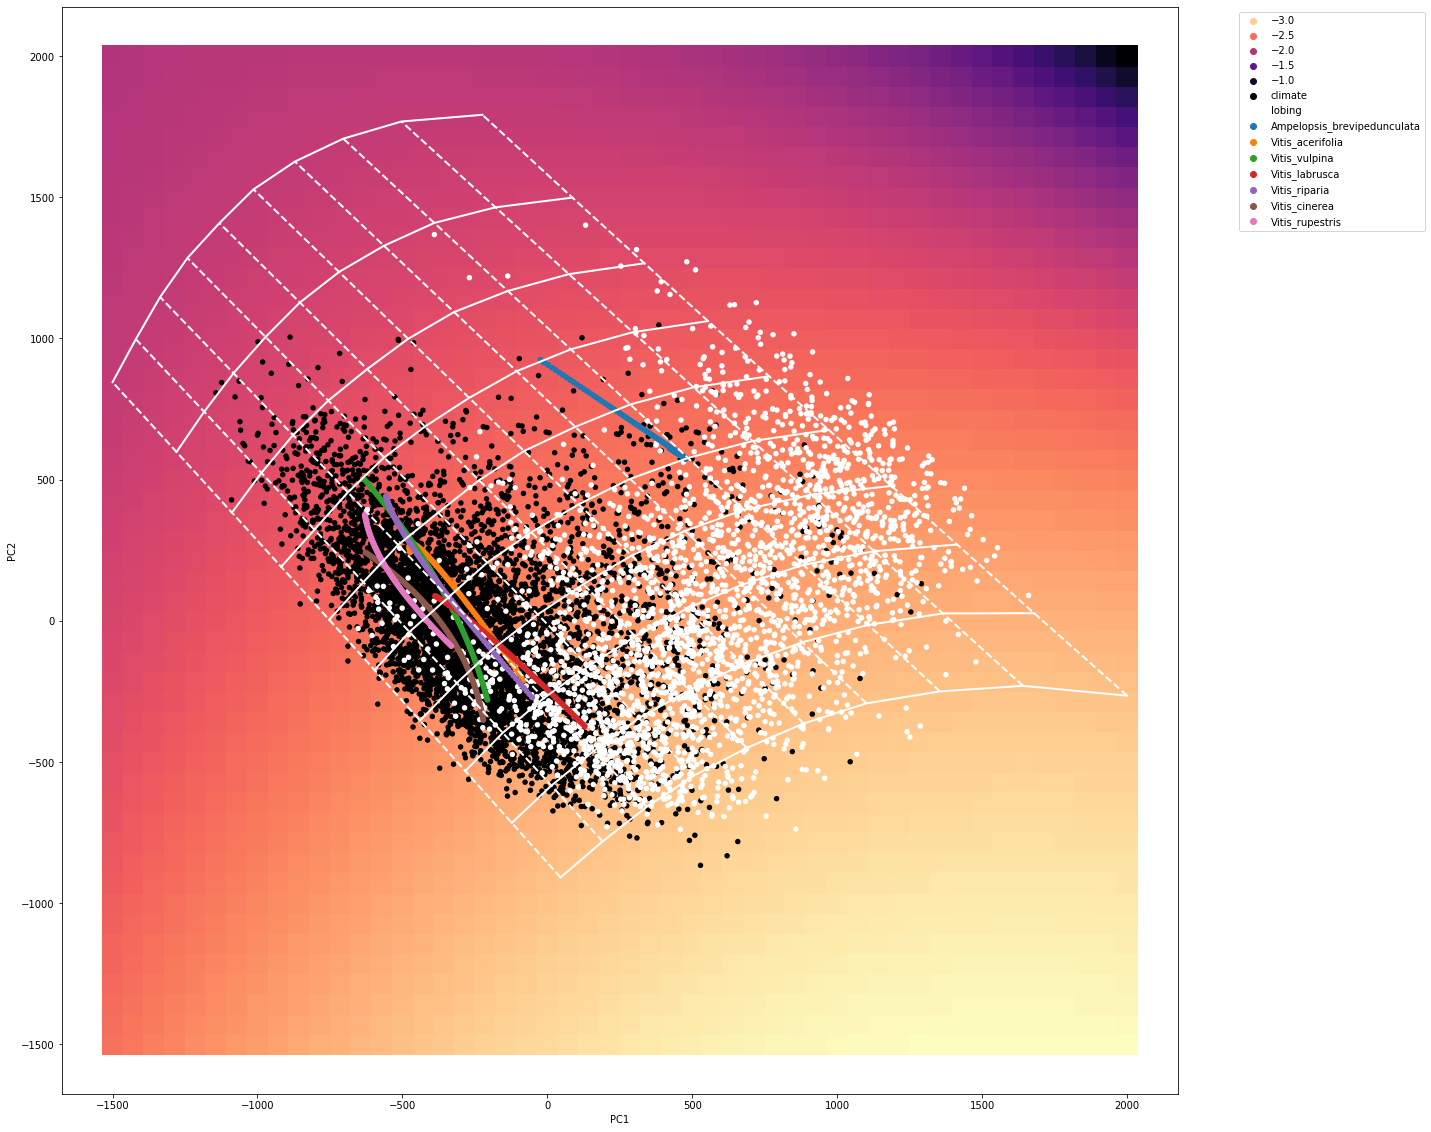

In [13]:
##################################################################
### VISUALIZE PCA OF EMPIRICAL DATA, VEIN TO BLADE BACKGROUND
### WITH PROJECTED SPECIES DEVELOPMENTAL MODELS AND CONTOUR LINES
##################################################################

plt.figure(figsize=(20,20))

# visualize ln(vein-to-blade) values
sns.scatterplot(data=inverse_df, x='PC1',y='PC2', color="k", hue="vein_to_blade", s=450, linewidth=0, alpha=1, palette="magma_r", cmap=True, marker="s")
# visualize empirical climate and lobing data points
sns.scatterplot(data=data_PCs_info, x='PC1',y='PC2', hue="dataset", s=30, linewidth=0, alpha=1, palette=["black","white"])
# visualize modeled species data
sns.scatterplot(data=spe_model_PCs, x='PC1',y='PC2', color="k", hue="species", linewidth=0, alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left') 

for i in range(len(PC1_vals_by_vtb)):
    
    curr_PC1 = PC1_vals_by_vtb[i]
    curr_PC2 = PC2_vals_by_vtb[i]

    # visualize vein to blade contour isolines
    plt.plot(curr_PC1, curr_PC2, zorder=1000, c="white", lw=2)
    
    distal_lines_PC1 = [PC1_vals_by_vtb[0][i],PC1_vals_by_vtb[1][i],PC1_vals_by_vtb[2][i],PC1_vals_by_vtb[3][i],PC1_vals_by_vtb[4][i],PC1_vals_by_vtb[5][i],PC1_vals_by_vtb[6][i],PC1_vals_by_vtb[7][i],PC1_vals_by_vtb[8][i],PC1_vals_by_vtb[9][i]]
    distal_lines_PC2 = [PC2_vals_by_vtb[0][i],PC2_vals_by_vtb[1][i],PC2_vals_by_vtb[2][i],PC2_vals_by_vtb[3][i],PC2_vals_by_vtb[4][i],PC2_vals_by_vtb[5][i],PC2_vals_by_vtb[6][i],PC2_vals_by_vtb[7][i],PC2_vals_by_vtb[8][i],PC2_vals_by_vtb[9][i]]

    # visualize distal lobing contour isolines
    plt.plot(distal_lines_PC1, distal_lines_PC2, zorder=1000, c="white", linestyle="--", lw=2)

plt.savefig("./figure_images/figure4a.jpg")


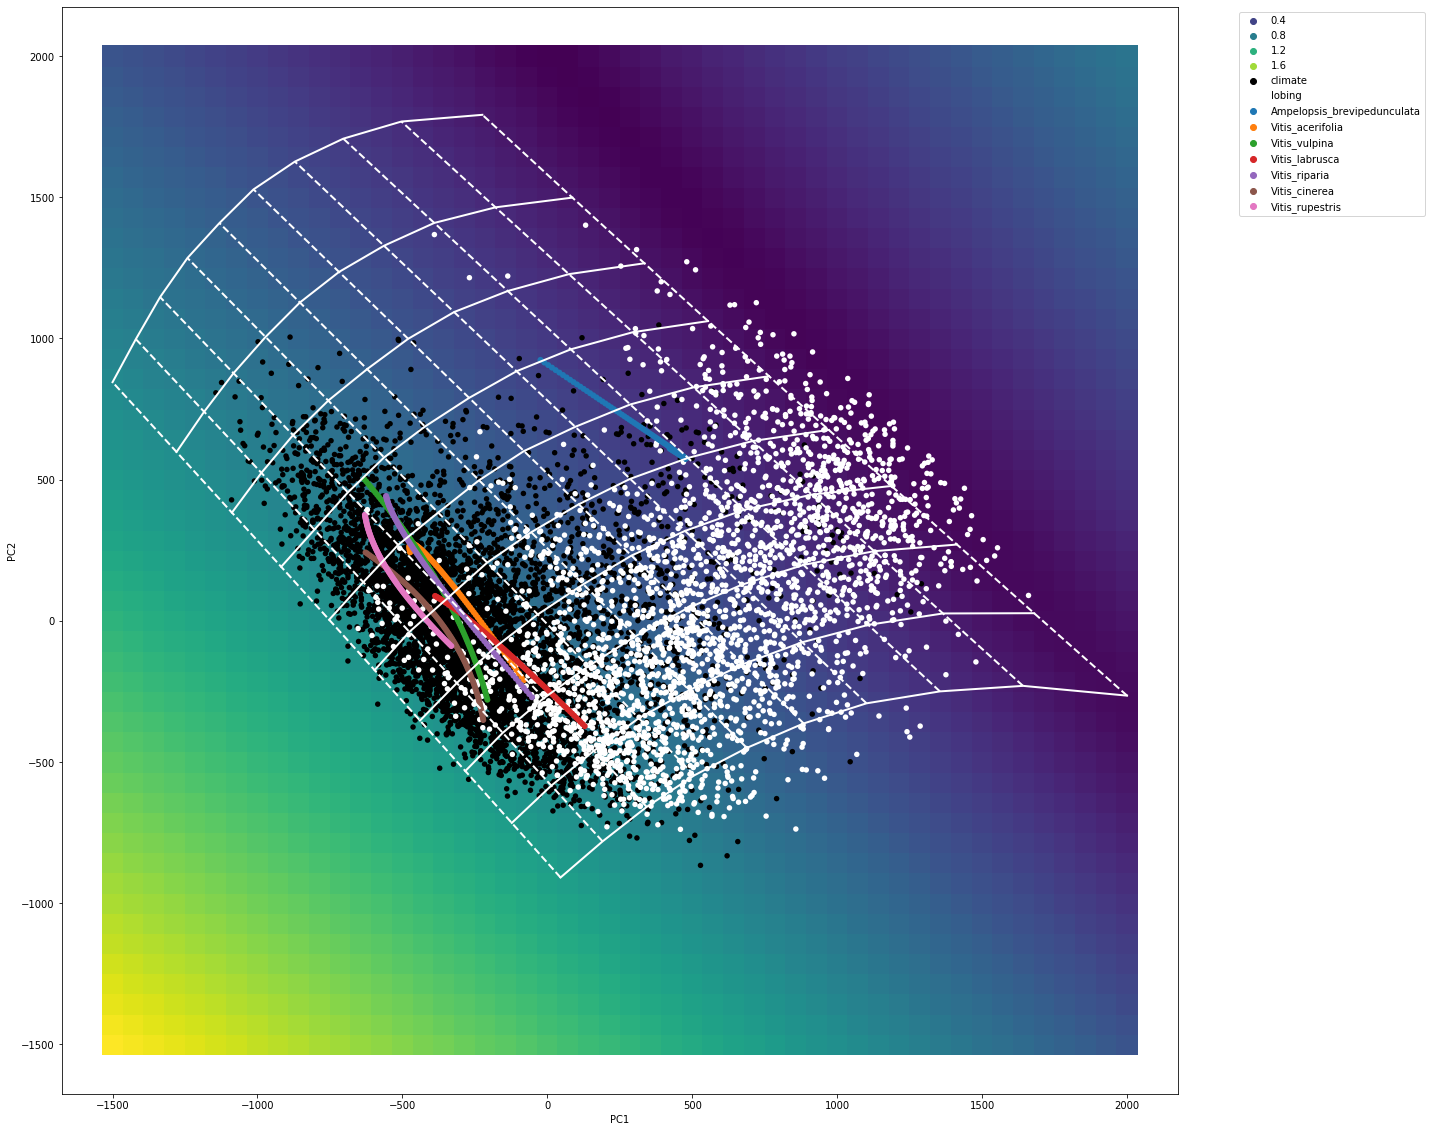

In [14]:
##################################################################
### VISUALIZE PCA OF EMPIRICAL DATA, DISTAL LOBING BACKGROUND
### WITH PROJECTED SPECIES DEVELOPMENTAL MODELS AND CONTOUR LINES
##################################################################

plt.figure(figsize=(20,20))

# visualize distal lobing values
sns.scatterplot(data=inverse_df, x='PC1',y='PC2', color="k", hue="distal_lobing", s=450, linewidth=0, alpha=1, palette="viridis", cmap=True, marker="s")
# visualize empirical climate and lobing data points
sns.scatterplot(data=data_PCs_info, x='PC1',y='PC2', hue="dataset", s=30, linewidth=0, alpha=1, palette=["black","white"])
# visualize modeled species data
sns.scatterplot(data=spe_model_PCs, x='PC1',y='PC2', color="k", hue="species", linewidth=0, alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left') 

for i in range(len(PC1_vals_by_vtb)):
    
    curr_PC1 = PC1_vals_by_vtb[i]
    curr_PC2 = PC2_vals_by_vtb[i]

    # visualize vein to blade contour isolines
    plt.plot(curr_PC1, curr_PC2, zorder=1000, c="white", lw=2)
    
    distal_lines_PC1 = [PC1_vals_by_vtb[0][i],PC1_vals_by_vtb[1][i],PC1_vals_by_vtb[2][i],PC1_vals_by_vtb[3][i],PC1_vals_by_vtb[4][i],PC1_vals_by_vtb[5][i],PC1_vals_by_vtb[6][i],PC1_vals_by_vtb[7][i],PC1_vals_by_vtb[8][i],PC1_vals_by_vtb[9][i]]
    distal_lines_PC2 = [PC2_vals_by_vtb[0][i],PC2_vals_by_vtb[1][i],PC2_vals_by_vtb[2][i],PC2_vals_by_vtb[3][i],PC2_vals_by_vtb[4][i],PC2_vals_by_vtb[5][i],PC2_vals_by_vtb[6][i],PC2_vals_by_vtb[7][i],PC2_vals_by_vtb[8][i],PC2_vals_by_vtb[9][i]]

    # visualize distal lobing contour isolines
    plt.plot(distal_lines_PC1, distal_lines_PC2, zorder=1000, c="white", linestyle="--", lw=2)

plt.savefig("./figure_images/figure4b.jpg")


# FIGURE 5
## VISUALIZE LEAVES AT EACH VEIN-TO-BLADE AND DISTAL LOBING ISOLINE INTERSECTION

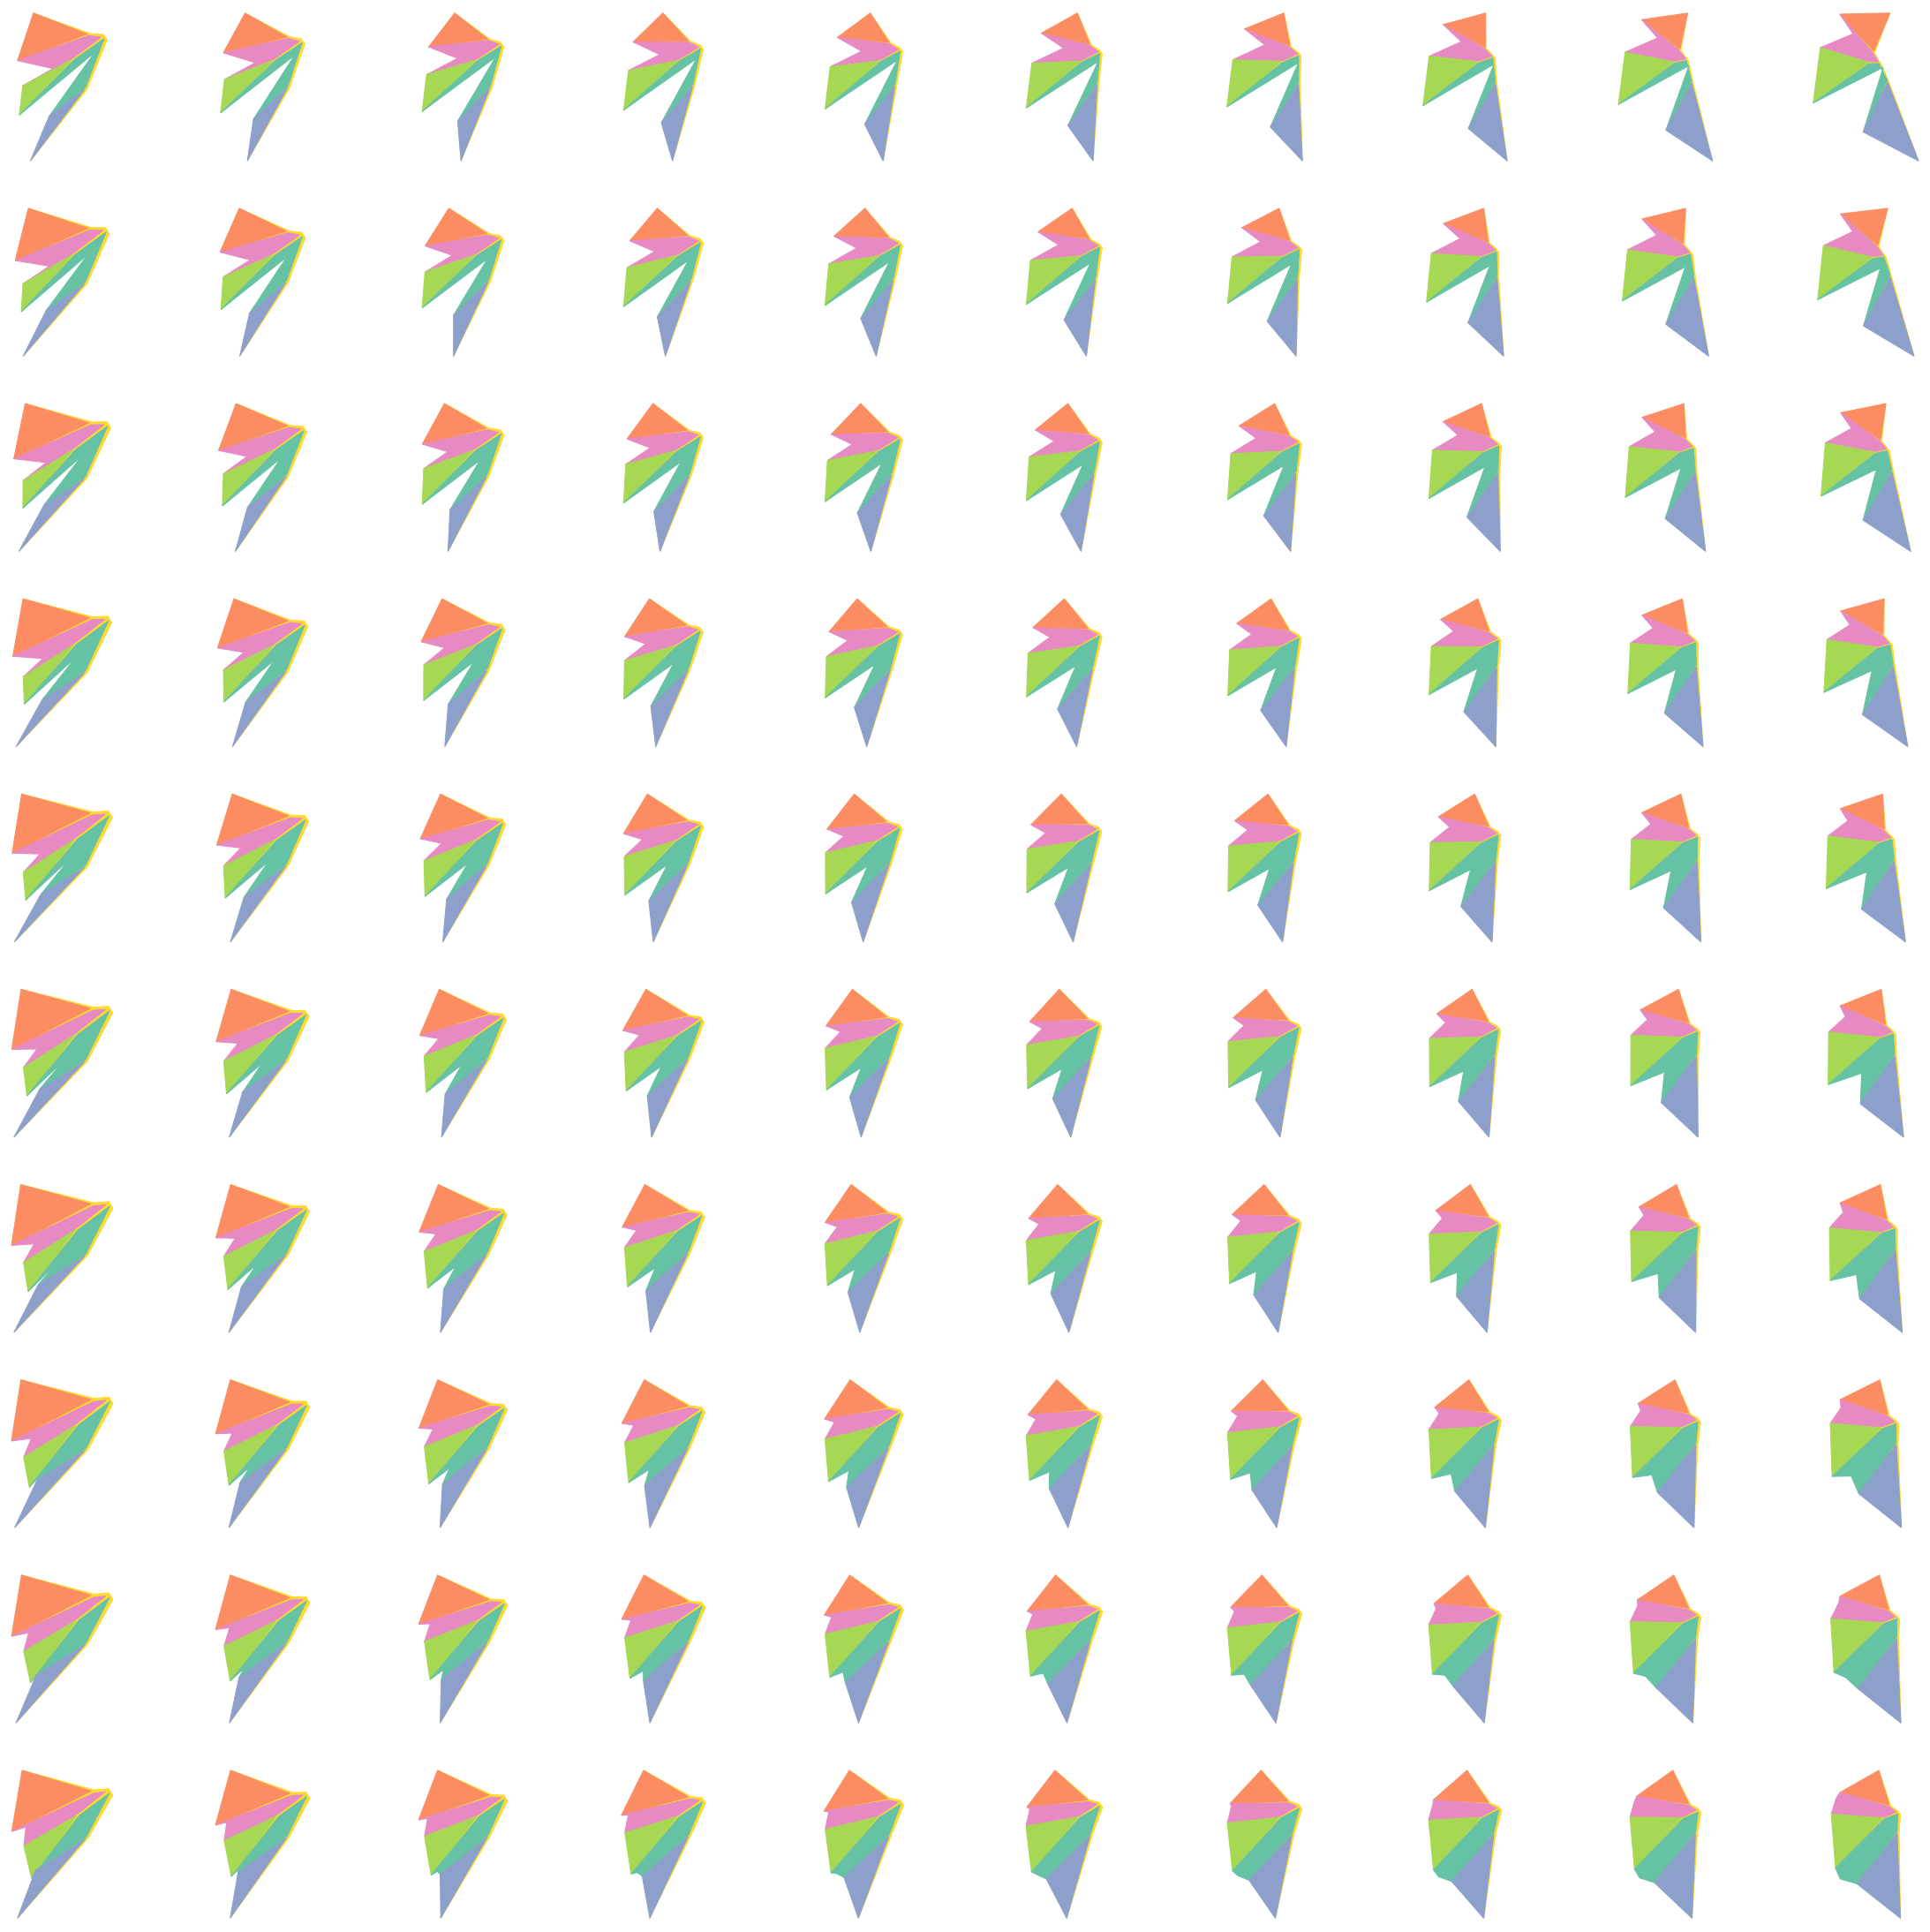

In [15]:
##################################################################
### VISUALIZE THEORETICAL LEAF SHAPES AT THE JUNCTION OF EACH
### VEIN TO BLADE AND DISTAL LOBING ISOLINE
##################################################################

vein_col = "#ffd92f"
prox_lobe_col = "#fc8d62"
prox_sinus_col = "#e78ac3"
dist_lobe_col = "#a6d854"
dist_sinus_col = "#66c2a5"
mid_lobe_col = "#8da0cb"
outline_col = "k"

counter = 0
plt.figure(figsize=(40,40))

for i in range(10):
    
    for j in range(10):
        
        j = 9-j

        inverse_PCA = pca.inverse_transform(np.array([PC1_vals_by_vtb[j][i],PC2_vals_by_vtb[j][i]]))

        x1val = inverse_PCA[0]
        y1val = inverse_PCA[1]
        x2val = inverse_PCA[2]
        y2val = inverse_PCA[3]
        x3val = inverse_PCA[4]
        y3val = inverse_PCA[5]
        x4val = inverse_PCA[6]
        y4val = inverse_PCA[7]
        x5val = inverse_PCA[8]
        y5val = inverse_PCA[9]
        x6val = inverse_PCA[10]
        y6val = inverse_PCA[11]
        x7val = inverse_PCA[12]
        y7val = inverse_PCA[13]
        x8val = inverse_PCA[14]
        y8val = inverse_PCA[15]
        x9val = inverse_PCA[16]
        y9val = inverse_PCA[17]
        x10val = inverse_PCA[18]
        y10val = inverse_PCA[19]
        x11val = inverse_PCA[20]
        y11val = inverse_PCA[21]
        x12val = inverse_PCA[22]
        y12val = inverse_PCA[23]
        x13val = inverse_PCA[24]
        y13val = inverse_PCA[25]
        x14val = inverse_PCA[26]
        y14val = inverse_PCA[27]
        x15val = inverse_PCA[28]
        y15val = inverse_PCA[29]
        x16val = inverse_PCA[30]
        y16val = inverse_PCA[31]
        x17val = inverse_PCA[32]
        y17val = inverse_PCA[33]
        x18val = inverse_PCA[34]
        y18val = inverse_PCA[35]
        x19val = inverse_PCA[36]
        y19val = inverse_PCA[37]
        x20val = inverse_PCA[38]
        y20val = inverse_PCA[39]
        x21val = inverse_PCA[40]
        y21val = inverse_PCA[41]

        counter += 1

        plt.subplot(10,10,counter)

        vein_xvals = [x1val,x6val,x14val,x5val,x15val,x7val,
                 x2val,x9val,x17val,x8val,x18val,x10val,
                 x3val,x12val,x20val,x11val,x21val,x13val,
                 x4val]
        vein_yvals = [y1val,y6val,y14val,y5val,y15val,y7val,
                 y2val,y9val,y17val,y8val,y18val,y10val,
                 y3val,y12val,y20val,y11val,y21val,y13val,
                 y4val]

        prox_lobe_xvals = [x5val,x14val,x15val]
        prox_lobe_yvals = [y5val,y14val,y15val]

        prox_sinus_xvals = [x2val,x7val,x15val,x16val,x17val,x9val]
        prox_sinus_yvals = [y2val,y7val,y15val,y16val,y17val,y9val]

        dist_lobe_xvals = [x8val,x17val,x18val]
        dist_lobe_yvals = [y8val,y17val,y18val]

        dist_sinus_xvals = [x3val,x10val,x18val,x19val,x20val,x12val]
        dist_sinus_yvals = [y3val,y10val,y18val,y19val,y20val,y12val]

        mid_lobe_xvals = [x11val,x20val,x21val]
        mid_lobe_yvals = [y11val,y20val,y21val]

        plt.fill(vein_xvals,vein_yvals, c=vein_col)
        #plt.plot(vein_xvals,vein_yvals, lw=1, c=outline_col)

        plt.fill(prox_lobe_xvals,prox_lobe_yvals, c=prox_lobe_col)
        #plt.plot(prox_lobe_xvals,prox_lobe_yvals, lw=1, c=outline_col)

        plt.fill(prox_sinus_xvals,prox_sinus_yvals, c=prox_sinus_col)
        #plt.plot(prox_sinus_xvals,prox_sinus_yvals, lw=1, c=outline_col)

        plt.fill(dist_lobe_xvals,dist_lobe_yvals, c=dist_lobe_col)
        #plt.plot(dist_lobe_xvals,dist_lobe_yvals, lw=1, c=outline_col)

        plt.fill(dist_sinus_xvals,dist_sinus_yvals, c=dist_sinus_col)
        #plt.plot(dist_sinus_xvals,dist_sinus_yvals, lw=1, c=outline_col)

        plt.fill(mid_lobe_xvals,mid_lobe_yvals, c=mid_lobe_col)
        #plt.plot(mid_lobe_xvals,mid_lobe_yvals, lw=1, c=outline_col)

        plt.gca().set_aspect("equal")
        plt.axis("off")
        
plt.savefig("./figure_images/figure5.jpg")